# CK0223 - Mineração de Dados

## Lista 03 - Análise de Dados

### Dados do discente:
**Nome**: Luiza Esther Martins Pessoa
**Matrícula**: 555516

### Vídeo Youtube:
[Mineração de Dados: Lista 03 - Análise de Dados (Explicando o código)](https://youtu.be/rjc0NUP_Dh4)

### GitHub:
[EstherMart - Análise de Dados](https://github.com/EstherMart/Data-Mining/blob/main/Lista03_AnaliseDeDados/analise_de_dados.ipynb)

---

### **(a)** Ler o dataset *fakeTelegram.BR_2022.csv*

Como realizado na [Lista 01 - Tratamento de Dados](https://github.com/EstherMart/Data-Mining/blob/main/Lista01_TratamentoDeDados/tratamento.ipynb) e na [Lista 02 - Extração de Dados](https://github.com/EstherMart/Data-Mining/tree/main/Lista02_ExtracaoDeDados), ler o dataset é o primeiro passo para iniciarmos a extraçãa, manipulação e tratamento dos dados. 

Para fazer isso, começamos importando as bibliotecas necessárias para leitura (`pandas`) e para download local da base de dados (`gdown`). Além disso, vale ressaltar que existem outras formas de realizar o upload para o repositório local, mas decidi seguir a lógica de puxar e realizar o download de base utilizando apenas o link disponibilizado pelo professor.

**Importante**: Alguns trechos de código serão reutilizados, visto que são as mesmas exigências em ambas as listas e tal solicitação já foi realizada nas listas anteriores.

In [32]:
# IMPORTAÇÃO DE BIBLIOTECAS
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import nltk
import networkx as nx
import re
from itertools import combinations
from collections import defaultdict
from scipy.stats import chi2_contingency
from scipy.stats import kstest, zscore
from scipy.stats import shapiro
from scipy.stats import spearmanr
from urllib.parse import urlparse
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from pyvis.network import Network # pip install pyvis

Fazendo o download do dataset para o repositório local

In [2]:
origem_url = 'https://drive.google.com/file/d/1c_hLzk85pYw-huHSnFYZM_gn-dUsYRDm/view'

# O ID do arquivo (necessário para fazer o download direto) está entre os últimos elementos da URL.
# Fazemos um split na URL usando '/' como separador e pegamos o penúltimo elemento da lista.
# Isso funciona porque a estrutura da URL é:
# https://drive.google.com/file/d/ID_DO_ARQUIVO/view
# E ao aplicar url.split('/'), o resultado será:
# ['https:', '', 'drive.google.com', 'file', 'd', 'ID_DO_ARQUIVO', 'view?...']
# Portanto, o ID está na posição -2 (penúltima).

file_id = origem_url.split('/')[-2]

# URL do arquivo no formato aceito pelo gdown
url = f'https://drive.google.com/uc?id={file_id}'

# Nome local do arquivo que será baixado
output = 'fakeTelegram.BR_2022.csv'

# Baixando o arquivo com gdown
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1c_hLzk85pYw-huHSnFYZM_gn-dUsYRDm
From (redirected): https://drive.google.com/uc?id=1c_hLzk85pYw-huHSnFYZM_gn-dUsYRDm&confirm=t&uuid=7447e205-7eec-4349-8b15-0863e2988e4a
To: c:\Users\esthe\Downloads\Data-Mining\Lista03_AnaliseDeDados\fakeTelegram.BR_2022.csv
100%|██████████| 224M/224M [00:49<00:00, 4.50MB/s] 


'fakeTelegram.BR_2022.csv'

Leitura do dataset utilizando o método `.read_csv()`, pois permite carregar dados estruturados a partir de arquivos *CSV* para um DataFrame do pandas, sendo uma estrutura tabular extremamente versátil para análise de dados e visualmente intuitiva.

In [2]:
df_inicial = pd.read_csv("fakeTelegram.BR_2022.csv")

Os códigos abaixo foram implementados apenas para fins de **visualização e verificação inicial dos dados carregados**, com o objetivo de:
- Obter uma compreensão rápida da dimensão do dataset
- Identificar os nomes das colunas disponíveis
- Realizar uma primeira checagem da integridade básica da estrutura de dados

In [3]:
# PARA MELHOR VISUALIZAÇÃO
print("Número de linhas:", df_inicial.shape[0])
print("Número de colunas:", df_inicial.shape[1])
print("\nColunas disponíveis:")
for i, col in enumerate(df_inicial.columns, 1):
    print(f"{i}. {col}")

Número de linhas: 557586
Número de colunas: 19

Colunas disponíveis:
1. date_message
2. id_member_anonymous
3. id_group_anonymous
4. media
5. media_type
6. media_url
7. has_media
8. has_media_url
9. trava_zap
10. text_content_anonymous
11. dataset_info_id
12. date_system
13. score_sentiment
14. score_misinformation
15. id_message
16. message_type
17. messenger
18. media_name
19. media_md5


In [4]:
# VISUALIZANDO AMOSTRAS INICIAIS E FINAIS DO DATASET
display(df_inicial.head().style.set_caption("Primeiros Registros").set_properties(**{
    'background-color': '#f8f9fa',
    'border': '1px solid #dee2e6',
    'color': '#212529',
    'max-width': '300px',
    'overflow': 'hidden',
    'text-overflow': 'ellipsis',
    'white-space': 'nowrap'
}))

display(df_inicial.tail().style.set_caption("Últimos Registros").set_properties(**{
    'background-color': '#f8f9fa',
    'border': '1px solid #dee2e6',
    'color': '#212529',
    'max-width': '300px',
    'overflow': 'hidden',
    'text-overflow': 'ellipsis',
    'white-space': 'nowrap'
}))

---

### **(b)** Remova os trava-zaps.

Este item será resolvido através da manipulação da coluna `trava_zap`, previamente identificada na análise inicial. A estratégia adotada considera o tamanho do dataset (557.586 registros) e segue um fluxo estruturado:

1. **Análise Preliminar**
    - Verificação do tipo de dado (dtype) e valores únicos na coluna `trava_zap`
    - Confirmação da proporção True/False/NaN (se aplicável)

In [3]:
# ANÁLISE PRELIMINAR
# Verificação do tipo e valores únicos
print(f"Tipo de dado: {df_inicial['trava_zap'].dtype}")
trava_dist = df_inicial['trava_zap'].value_counts(dropna=False)
display(trava_dist.to_frame().style.set_caption("Contagem de valores distintos em trava_zap"))

# Verificação de linhas que devem ser removidas
print(f"Registros com trava_zap que precisam ser removidos: {trava_dist.get(True, 0):,}")

Tipo de dado: bool


Registros com trava_zap que precisam ser removidos: 16


2. **Processamento por Chunks**
    - Divisão do dataset em blocos de 1.000 linhas para:
        - Otimização de memória
        - Facilidade de debug
        - Monitoramento do progresso

In [4]:
# Parâmetros do chunk -- 1000 linhas 
CHUNK_SIZE = 1000
total_chunks = (len(df_inicial) // CHUNK_SIZE) + 1
df_sem_trava_zap = pd.DataFrame() # Criação de DataFrame Seguro para controle de variáveis.

print(f"\033[1mProcessando {total_chunks} chunks de {CHUNK_SIZE} registros cada:\033[0m")

for i, chunk in enumerate(np.array_split(df_inicial, total_chunks)):
    # Filtro principal -- linhas que possuem trava zap, isto é, trava_zap = True
    chunk_filtrado = chunk[chunk['trava_zap'] != True]
    
    # Concatenção segura -- recebendo apenas os blocos onde trava_zap = False
    df_sem_trava_zap = pd.concat([df_sem_trava_zap, chunk_filtrado], ignore_index=True)
    
    # Log de progresso para controle da análise
    if (i+1) % 10 == 0:
        print(f"Processado chunk {i+1}/{total_chunks} | Registros retidos: {len(df_sem_trava_zap):,}")

Processando 558 chunks de 1000 registros cada:


c:\Users\esthe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processado chunk 10/558 | Registros retidos: 10,000
Processado chunk 20/558 | Registros retidos: 20,000
Processado chunk 30/558 | Registros retidos: 29,999
Processado chunk 40/558 | Registros retidos: 39,999
Processado chunk 50/558 | Registros retidos: 49,999
Processado chunk 60/558 | Registros retidos: 59,999
Processado chunk 70/558 | Registros retidos: 69,999
Processado chunk 80/558 | Registros retidos: 79,999
Processado chunk 90/558 | Registros retidos: 89,998
Processado chunk 100/558 | Registros retidos: 99,998
Processado chunk 110/558 | Registros retidos: 109,998
Processado chunk 120/558 | Registros retidos: 119,998
Processado chunk 130/558 | Registros retidos: 129,998
Processado chunk 140/558 | Registros retidos: 139,998
Processado chunk 150/558 | Registros retidos: 149,992
Processado chunk 160/558 | Registros retidos: 159,982
Processado chunk 170/558 | Registros retidos: 169,972
Processado chunk 180/558 | Registros retidos: 179,962
Processado chunk 190/558 | Registros retidos: 1

In [25]:
# Relatório final
print("\033[1mRelatório de Remoção:\033[0m")
print(f"• Registros originais: {len(df_inicial):,}")
print(f"• Registros removidos: {trava_dist.get(True, 0):,}")
print(f"• Registros restantes: {len(df_sem_trava_zap):,}") 

# Visualização dos dados que foram removidos
if trava_dist.get(True, 0) > 0:
    display(
        df_inicial[df_inicial['trava_zap'] == True].head(16)  
    )

Relatório de Remoção:
• Registros originais: 557,586
• Registros removidos: 16
• Registros restantes: 557,570


date_message               id_member_anonymous  \
21944   2022-10-07 07:46:52                               NaN   
89109   2022-10-16 00:45:02  8a30ac374bc4b5930eaf0667a178546a   
294541  2022-10-04 14:22:47  39ee10516124280a22f1798f2a41f9a7   
324567  2022-10-25 14:55:55  e003fbb6ffedb1838e42360d41cab314   
389164  2022-10-30 20:19:52                               NaN   
423083  2022-11-03 00:40:23                               NaN   
466735  2022-11-07 20:47:35  4a498818da925377eff2606a260cfa45   
467297  2022-11-08 10:07:14  4a498818da925377eff2606a260cfa45   
471273  2022-11-08 20:37:52  4a498818da925377eff2606a260cfa45   
478270  2022-11-09 19:50:12  4a498818da925377eff2606a260cfa45   
483425  2022-11-10 02:28:43  4a498818da925377eff2606a260cfa45   
489757  2022-11-10 20:55:00  4a498818da925377eff2606a260cfa45   
489758  2022-11-10 20:55:01  4a498818da925377eff2606a260cfa45   
492781  2022-11-11 09:50:37  4a498818da925377eff2606a260cfa45   
493561  2022-11-09 06:37:51  4a498818da925377eff2606a260cfa45   
493663  2022-11-09 07:48:24                               NaN   

                      id_group_anonymous  \
21944   c712c1b704c22bd0cef50bc06125cdbd   
89109   e56ec342fc599ebb4ed89655eb6f03aa   
294541  959f13e0079883060632c74ffc81c547   
324567  5b10d7739171149be6d9961e3350c071   
389164  c8f2de56550ed0bf85249608b7ead93d   
423083  4d3712f5a117e36180d4b4cbd07c540e   
466735  f61777908059b318385882ff47b15c33   
467297  f61777908059b318385882ff47b15c33   
471273  f61777908059b318385882ff47b15c33   
478270  f61777908059b318385882ff47b15c33   
483425  f61777908059b318385882ff47b15c33   
489757  f61777908059b318385882ff47b15c33   
489758  f61777908059b318385882ff47b15c33   
492781  f61777908059b318385882ff47b15c33   
493561  f61777908059b318385882ff47b15c33   
493663  a26d427bec046513e600d165e98660ae   

                                       media media_type media_url  has_media  \
21944                                    NaN        NaN       NaN      False   
89109                                    NaN        NaN       NaN      False   
294541                                   NaN        NaN       NaN      False   
324567                                   NaN        NaN       NaN      False   
389164                                   NaN        NaN       NaN      False   
423083                                   NaN        NaN       NaN      False   
466735                                   NaN        NaN       NaN      False   
467297                                   NaN        NaN       NaN      False   
471273                                   NaN        NaN       NaN      False   
478270                                   NaN        NaN       NaN      False   
483425                                   NaN        NaN       NaN      False   
489757                                   NaN        NaN       NaN      False   
489758                                   NaN        NaN       NaN      False   
492781                                   NaN        NaN       NaN      False   
493561                                   NaN        NaN       NaN      False   
493663  d4c34e18a0d3fc82051327e81f0afa7a.jpg  image/jpg       NaN       True   

        has_media_url  trava_zap text_content_anonymous  dataset_info_id  \
21944           False       True                    NaN                5   
89109           False       True                    NaN                5   
294541          False       True                    NaN                5   
324567          False       True                    NaN                5   
389164          False       True                    NaN                5   
423083          False       True                    NaN                5   
466735          False       True                    NaN                5   
467297          False       True                    NaN                5   
471273          False       True                    NaN                5   
478270          False       True       

---

### **(c)** Remover as linhas repetidas (duplicadas).

Após realizar a filtragem das mensagens identificadas como "trava-zaps", é fundamental para garantir que análises estatísticas e inferências posteriores não sejam distorcidas por registros repetidos, que poderiam inflar contagens ou enviesar métricas como proporções, médias e distribuições.

A remoção de linhas repetidas foi realizada utilizando o método `drop_duplicates()` do Pandas, aplicado diretamente sobre o `df_sem_trava_zap`. Esse método verifica todas as colunas do DataFrame e elimina quaisquer registros que sejam completamente idênticos em todas elas. Abaixo está o código utilizado:

In [5]:
# Identificação das linhas duplicadas
duplicatas = df_sem_trava_zap[df_sem_trava_zap.duplicated(keep=False)]

# Relatório de remoção de duplicatas
print("\033[1mRelatório de Remoção de Duplicatas:\033[0m")
print(f"• Registros antes da remoção: {len(df_sem_trava_zap):,}")
print(f"• Duplicatas encontradas: {len(duplicatas):,}")
print(f"• Registros únicos após remoção: {len(df_sem_trava_zap.drop_duplicates()):,}")

# Visualização das linhas duplicadas que serão removidas
if not duplicatas.empty:
    display(duplicatas.sort_values(by='id_message').head(10))  # Mostra 10 duplicadas ordenadas por id_message

Relatório de Remoção de Duplicatas:
• Registros antes da remoção: 557,570
• Duplicatas encontradas: 0
• Registros únicos após remoção: 557,570


---

### **(d)** Remover textos com menos de 5 palavras. 

Nesta etapa, o objetivo foi eliminar mensagens com pouco conteúdo textual, mais especificamente aquelas com menos de 5 palavras. Isso se justifica pela baixa relevância semântica de mensagens muito curtas, que tendem a conter ruídos, emojis soltos, confirmações ("sim", "ok", "não") ou abreviações que pouco contribuem para análises mais profundas.

Para isso, foi criada uma nova feature chamada `qtd_palavras`, responsável por contabilizar o número de palavras em cada mensagem da coluna `text_content_anonymous`. Com essa informação, filtramos o DataFrame mantendo apenas registros com 5 ou mais palavras.

O relatório abaixo resume o resultado dessa filtragem.

Além disso, uma amostra das mensagens descartadas foi exibida para inspeção manual e validação da decisão tomada.

In [6]:
# Criação da feature 'qtd_palavras' com a contagem de palavras na mensagem
df_sem_trava_zap['qtd_palavras'] = df_sem_trava_zap['text_content_anonymous'].astype(str).apply(lambda x: len(x.split()))

# Identificação das mensagens com menos de 5 palavras
mensagens_curta = df_sem_trava_zap[df_sem_trava_zap['qtd_palavras'] < 5]

# Filtragem: apenas mensagens com 5 ou mais palavras
df_sem_mensagens_curtas = df_sem_trava_zap[df_sem_trava_zap['qtd_palavras'] >= 5].reset_index(drop=True)

# Relatório de remoção
print("\033[1mRelatório de Remoção de Mensagens Curtas:\033[0m")
print(f"• Registros antes da remoção: {len(df_sem_trava_zap):,}")
print(f"• Mensagens com menos de 5 palavras removidas: {len(mensagens_curta):,}")
print(f"• Registros restantes: {len(df_sem_mensagens_curtas):,}")

# Visualização das mensagens que foram removidas
if not mensagens_curta.empty:
    display(mensagens_curta[['text_content_anonymous', 'qtd_palavras']].sort_values(by='qtd_palavras').head(10)) # Apenas os 10 primeiros casos

Relatório de Remoção de Mensagens Curtas:
• Registros antes da remoção: 557,570
• Mensagens com menos de 5 palavras removidas: 218,284
• Registros restantes: 339,286


text_content_anonymous  qtd_palavras
4                                               NaN             1
337292                                          NaN             1
337293                                          NaN             1
337294                                          NaN             1
337295                                          NaN             1
337296                                          NaN             1
337298                 https://youtu.be/sOc-TRTh-7o             1
337299  https://www.youtube.com/watch?v=s4vdVj4VCvk             1
337300                                          NaN             1
337301                                          NaN             1

---

### **(e)** Para cada atributo numérico apresente

Antes de calcular as medidas e tabelas, foi realizada uma análise exploratória inicial para mapear os atributos numéricos disponíveis e avaliar possíveis valores ausentes, formatos incorretos e dispersões.

O comando `.info()` permitiu inspecionar os tipos de dados presentes no DataFrame, enquanto o `.describe()` forneceu um resumo estatístico geral (contagem, média, desvio padrão, mínimo, percentis e máximo) das colunas numéricas.

Essa etapa é fundamental para compreender a estrutura dos dados e orientar as análises estatísticas subsequentes de forma segura e eficiente.

In [11]:
# Visualização geral das colunas e tipos
print("\033[1mInformações do DataFrame:\033[0m")
df_sem_mensagens_curtas.info()

# Estatísticas descritivas básicas para colunas numéricas
print("\n\033[1mResumo Estatístico das Colunas Numéricas:\033[0m")
display(df_sem_mensagens_curtas.describe())

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339286 entries, 0 to 339285
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date_message            339286 non-null  object 
 1   id_member_anonymous     142880 non-null  object 
 2   id_group_anonymous      339286 non-null  object 
 3   media                   126431 non-null  object 
 4   media_type              126431 non-null  object 
 5   media_url               82936 non-null   object 
 6   has_media               339286 non-null  bool   
 7   has_media_url           339286 non-null  bool   
 8   trava_zap               339286 non-null  bool   
 9   text_content_anonymous  339286 non-null  object 
 10  dataset_info_id         339286 non-null  int64  
 11  date_system             339286 non-null  object 
 12  score_sentiment         339239 non-null  float64
 13  score_misinformation    167224 non-null  float64

dataset_info_id  score_sentiment  score_misinformation    id_message  \
count         339286.0    339239.000000         167224.000000  3.392860e+05   
mean               5.0         0.022025              0.312263  4.219091e+05   
std                0.0         0.529724              0.293703  4.843659e+05   
min                5.0        -1.000000              0.000003  2.000000e+00   
25%                5.0        -0.381800              0.078466  1.991900e+04   
50%                5.0         0.000000              0.197592  8.490950e+04   
75%                5.0         0.505300              0.490396  9.730932e+05   
max                5.0         0.999200              1.000000  1.516436e+06   

        qtd_palavras  
count  339286.000000  
mean       42.027817  
std        74.050521  
min         5.000000  
25%        14.000000  
50%        20.000000  
75%        40.000000  
max      1261.000000

#### 1. **Medidas de Tendência Central**

Para cada atributo numérico identificado no dataset, foram calculadas as principais medidas de tendência central e de dispersão, sendo:

- **Média**: valor médio da distribuição.
- **Mediana**: valor central quando os dados estão ordenados.
- **Moda**: valor que mais se repete.
- **Desvio Padrão**: indica a dispersão dos dados em relação à média.
- **Mínimo e Máximo**: ajudam a entender a amplitude da distribuição.
- **Valores Nulos**: quantidade de registros ausentes (importante para avaliar a qualidade do dado).

Essas medidas fornecem uma visão geral do comportamento central dos dados e ajudam a identificar possíveis distorções, outliers e padrões relevantes.

In [11]:
# Seleção das colunas numéricas com base nos tipos
atributos_numericos = df_sem_mensagens_curtas.select_dtypes(include=['int64', 'float64']).columns

# Lista para armazenar os resultados
medidas_central = []

# Loop pelas colunas numéricas
for coluna in atributos_numericos:
    serie = df_sem_mensagens_curtas[coluna].dropna()  # Ignora valores nulos
    media = serie.mean()
    mediana = serie.median()
    moda = serie.mode().iloc[0] if not serie.mode().empty else 'N/A'
    desvio = serie.std()
    minimo = serie.min()
    maximo = serie.max()
    total_nulos = df_sem_mensagens_curtas[coluna].isna().sum()
    
    medidas_central.append({
        'Atributo': coluna,
        'Média': round(media, 3),
        'Mediana': round(mediana, 3),
        'Moda': moda,
        'Desvio Padrão': round(desvio, 3),
        'Mínimo': minimo,
        'Máximo': maximo,
        'Valores Nulos': total_nulos
    })

# Criação do DataFrame com os resultados
df_medidas_central = pd.DataFrame(medidas_central)

# Exibição formatada
display(df_medidas_central.sort_values(by='Atributo'))


Atributo       Média    Mediana         Moda  Desvio Padrão  \
0       dataset_info_id       5.000      5.000     5.000000          0.000   
3            id_message  421909.079  84909.500  1014.000000     484365.886   
4          qtd_palavras      42.028     20.000    15.000000         74.051   
2  score_misinformation       0.312      0.198     0.110628          0.294   
1       score_sentiment       0.022      0.000     0.000000          0.530   

     Mínimo        Máximo  Valores Nulos  
0  5.000000  5.000000e+00              0  
3  2.000000  1.516436e+06              0  
4  5.000000  1.261000e+03              0  
2  0.000003  1.000000e+00         172062  
1 -1.000000  9.992000e-01             47

#### 2. **Medidas de Variabilidade**


Calcular as medidas de variabilidade permitem compreender o grau de dispersão das variáveis numéricas presentes no dataset. Esse tipo de análise é fundamental para avaliar a homogeneidade ou heterogeneidade dos dados, além de fornecer suporte para interpretações mais robustas nas etapas seguintes.

As principais medidas utilizadas foram:

- **Desvio padrão:** avalia o quanto, em média, os valores se distanciam da média. (também calculada no item anterior)
- **Variância:** representa o quadrado do desvio padrão, destacando a variabilidade dos dados.
- **Amplitude:** diferença entre o valor máximo e o mínimo, mostrando a extensão total dos dados.
- **Intervalo interquartílico (IQR):** mede a dispersão dos dados ao redor da mediana, sendo robusto contra outliers.


Pontos levados em consideração
- as variáveis **`score_sentiment`** e **`score_misinformation`** apresentam níveis distintos de variabilidade. 
- A análise do desvio padrão e da variância indica o quanto os escores se dispersam ao redor de suas médias, sendo que valores mais altos apontam para maior heterogeneidade.
- A amplitude fornece uma visão geral do intervalo total observado nos dados, enquanto o intervalo interquartílico (IQR) permite avaliar a dispersão ao redor da mediana, sendo uma métrica menos sensível a valores extremos.

In [14]:
# Seleção das colunas numéricas com base nos tipos
atributos_numericos = df_sem_mensagens_curtas.select_dtypes(include=['int64', 'float64']).columns

# Lista para armazenar os resultados
medidas_variabilidade = []

# Loop pelas colunas numéricas
for coluna in atributos_numericos:
    serie = df_sem_mensagens_curtas[coluna].dropna()  # Ignora valores nulos
    desvio = serie.std()
    variancia = serie.var()
    amplitude = serie.max() - serie.min()
    iqr = serie.quantile(0.75) - serie.quantile(0.25)
    total_nulos = df_sem_mensagens_curtas[coluna].isna().sum()
    
    medidas_variabilidade.append({
        'Atributo': coluna,
        'Desvio Padrão': round(desvio, 3),
        'Variância': round(variancia, 3),
        'Amplitude': round(amplitude, 3),
        'Intervalo Interquartílico (IQR)': round(iqr, 3),
        'Valores Nulos': total_nulos
    })

# Criação do DataFrame com os resultados
df_medidas_variabilidade = pd.DataFrame(medidas_variabilidade)

# Exibição formatada
display(df_medidas_variabilidade.sort_values(by='Atributo'))


Atributo  Desvio Padrão     Variância    Amplitude  \
0       dataset_info_id          0.000  0.000000e+00        0.000   
3            id_message     484365.886  2.346103e+11  1516434.000   
4          qtd_palavras         74.051  5.483480e+03     1256.000   
2  score_misinformation          0.294  8.600000e-02        1.000   
1       score_sentiment          0.530  2.810000e-01        1.999   

   Intervalo Interquartílico (IQR)  Valores Nulos  
0                            0.000              0  
3                       953174.250              0  
4                           26.000              0  
2                            0.412         172062  
1                            0.887             47

#### 3. **Tabela de Frequência e Histograma**

- A **Tabela de Frequência** permite observar a distribuição discreta dos valores, identificando repetições, padrões ou lacunas nos dados.
- O **Histograma** é uma representação gráfica que facilita a visualização da distribuição, assimetrias e presença de outliers. Além disso, adicionamos a linha de densidade (`kde`) para ilustrar a tendência de distribuição dos dados.

Escolha das Bibliotecas:

- **Matplotlib:** biblioteca base para geração de gráficos, oferecendo controle total sobre a estética e personalização das visualizações.
- **Seaborn:** escolhido para criar histogramas com aparência mais elegante e informativa, integrando facilmente a curva de densidade (`kde=True`), o que facilita a interpretação da distribuição dos dados.



Tabela de Frequência para: dataset_info_id


dataset_info_id
5    339286
Name: count, dtype: int64

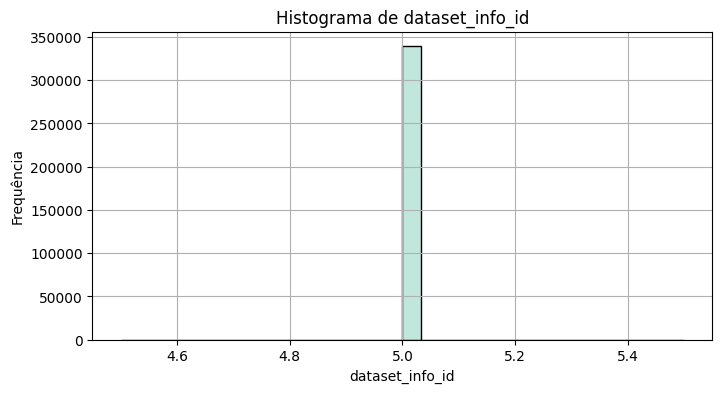


Tabela de Frequência para: score_sentiment


score_sentiment
-1.0000     7
-0.9999    57
-0.9998    18
-0.9997     2
-0.9996     7
           ..
 0.9987     3
 0.9988     1
 0.9989    11
 0.9990     2
 0.9992    11
Name: count, Length: 7807, dtype: int64

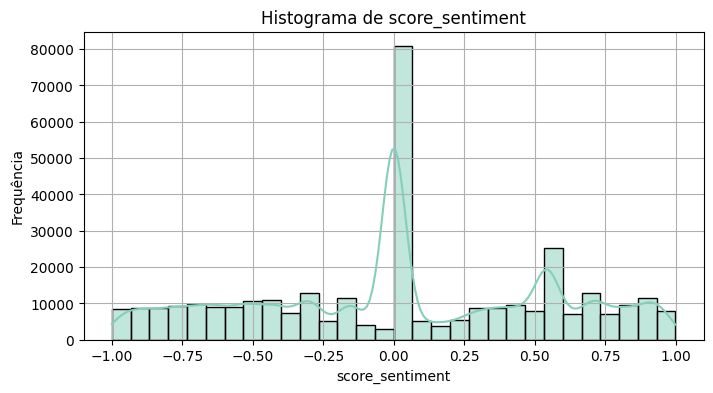


Tabela de Frequência para: score_misinformation


score_misinformation
0.000003    1
0.000025    1
0.000042    1
0.000056    1
0.000067    1
           ..
1.000000    3
1.000000    1
1.000000    6
1.000000    1
1.000000    2
Name: count, Length: 100588, dtype: int64

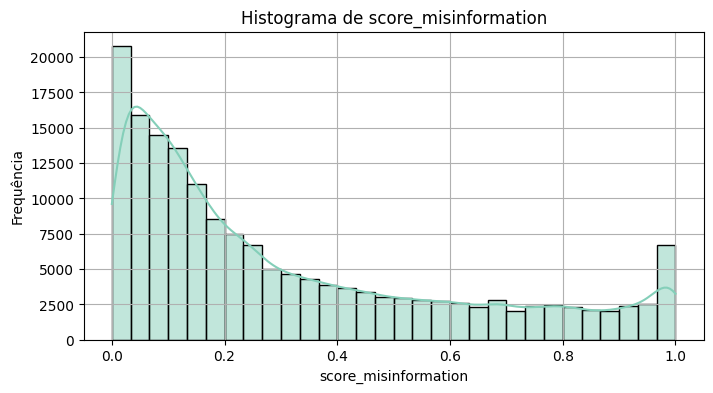


Tabela de Frequência para: id_message


id_message
2          1
3          1
4          1
5          1
6          1
          ..
1516403    1
1516410    1
1516422    1
1516427    1
1516436    1
Name: count, Length: 232563, dtype: int64

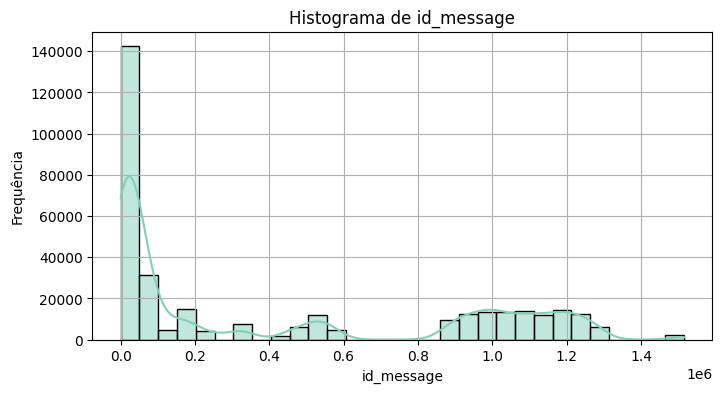


Tabela de Frequência para: qtd_palavras


qtd_palavras
5       5480
6       5286
7       4140
8       3251
9       3810
        ... 
926       24
943        1
993        8
994        7
1261       3
Name: count, Length: 748, dtype: int64

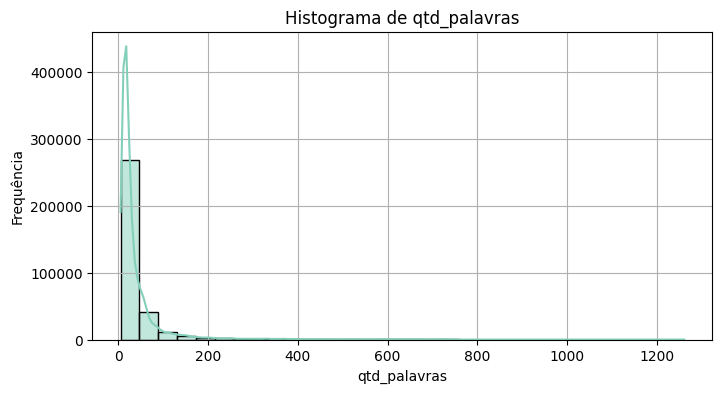

In [29]:
# Seleção das colunas numéricas com base nos tipos
atributos_numericos = df_sem_mensagens_curtas.select_dtypes(include=['int64', 'float64']).columns

# Loop pelas colunas numéricas
for coluna in atributos_numericos:
    serie = df_sem_mensagens_curtas[coluna].dropna()
    
    # Tabela de Frequência
    frequencia = serie.value_counts().sort_index()
    print(f"\nTabela de Frequência para: {coluna}")
    display(frequencia)
    
    
    # Seleciona uma cor da paleta BuGn
    bu_gn_color = sns.color_palette("BuGn", as_cmap=False)[2]  # Seleciona um tom intermediário

    # Histograma
    plt.figure(figsize=(8, 4))
    sns.histplot(serie, bins=30, kde=True, color=bu_gn_color)
    plt.title(f'Histograma de {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

#### 4. **Boxplot**

Como parte da análise exploratória, o boxplot é uma ferramenta estatística fundamental para visualizar:

- A **distribuição dos dados**.
- A presença de **outliers**.
- A **dispersão** e possíveis **assimetrias**.

A escolha da paleta de cores **"BuGn"** visa garantir uma apresentação visual agradável, profissional e consistente ao longo do notebook, reforçando o padrão estético adotado.

Além disso, essa representação facilita a identificação rápida de variáveis que podem apresentar comportamentos anômalos ou dados extremos, elementos importantes para orientar etapas posteriores da análise.

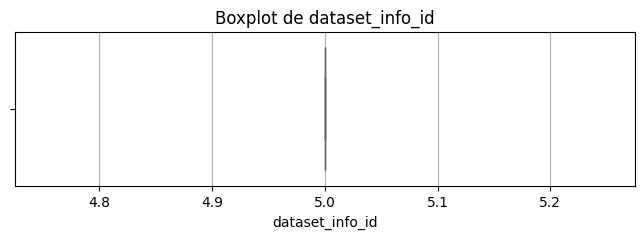

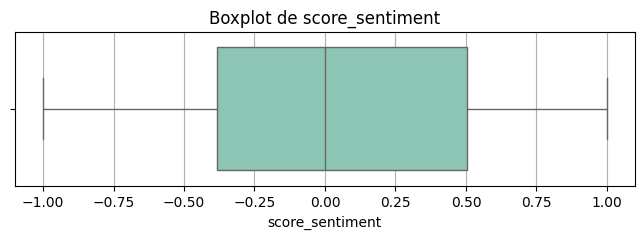

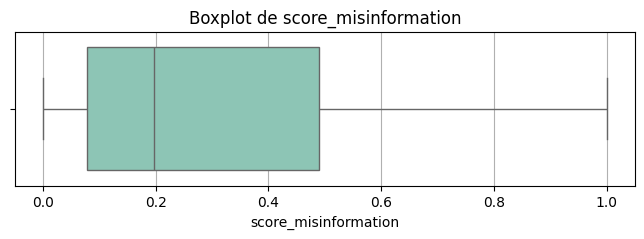

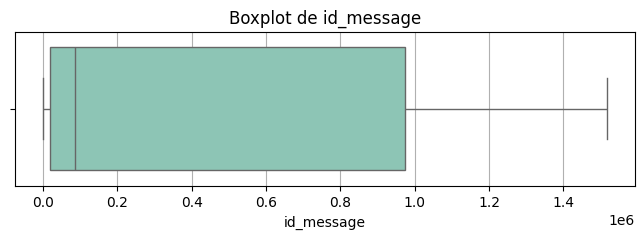

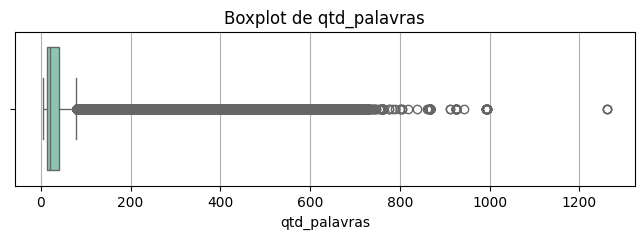

In [27]:
# Seleção das colunas numéricas com base nos tipos
atributos_numericos = df_sem_mensagens_curtas.select_dtypes(include=['int64', 'float64']).columns

# Loop pelas colunas numéricas
for coluna in atributos_numericos:
    serie = df_sem_mensagens_curtas[coluna].dropna()

    bu_gn_color = sns.color_palette("BuGn", as_cmap=False)[2]  # Seleciona um tom intermediário

    # Boxplot
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=serie, color=bu_gn_color)
    plt.title(f'Boxplot de {coluna}')
    plt.xlabel(coluna)
    plt.grid(True, axis='x')
    plt.show()

#### 5. **QQ-Plot**

Análise Gráfica: QQ-Plot por Atributo Numérico

Os **QQ-Plots** (*Quantile-Quantile Plots*) permite avaliar graficamente se a distribuição dos dados de cada variável segue uma **distribuição normal**.

Justificativa do Uso da Biblioteca `scipy.stats`

Nesta etapa da análise, utilizamos a função `probplot` da biblioteca **SciPy** (`scipy.stats`) para a construção dos **QQ-Plots**.

A **SciPy** (Scientific Python) é uma biblioteca robusta para computação científica e estatística, amplamente utilizada em análises de dados por oferecer:

- **Funções estatísticas avançadas**.
- Testes de hipóteses e análises de distribuição.
- Ferramentas de modelagem matemática e processamento de sinais.

No contexto desta análise, o módulo `scipy.stats` foi essencial para:

- **Gerar QQ-Plots** que comparam os quantis da distribuição amostral com os da distribuição normal teórica.
- Avaliar graficamente a **adequação dos dados à normalidade**, uma etapa fundamental para orientar a escolha de métodos estatísticos apropriados.


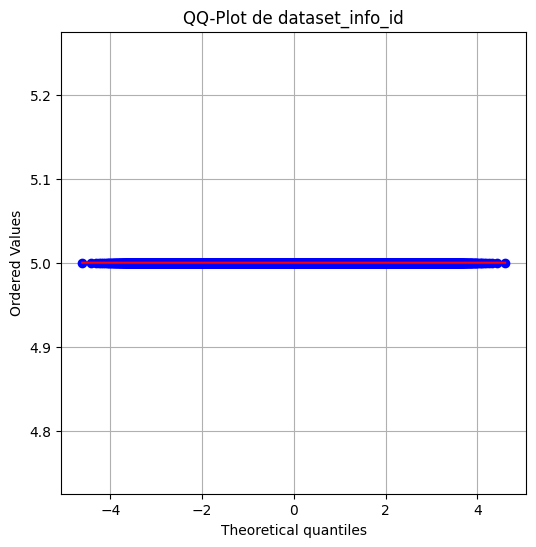

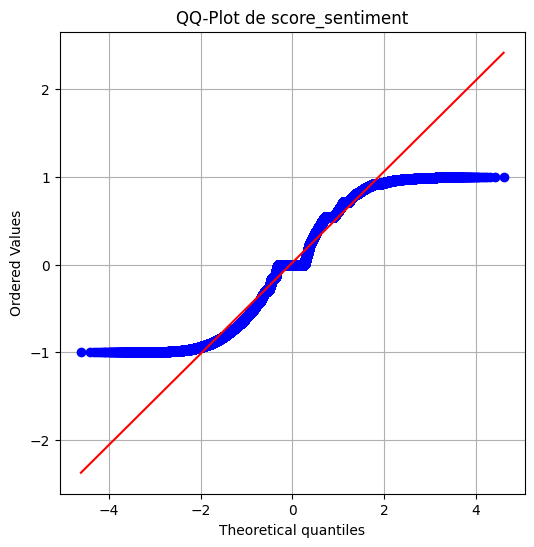

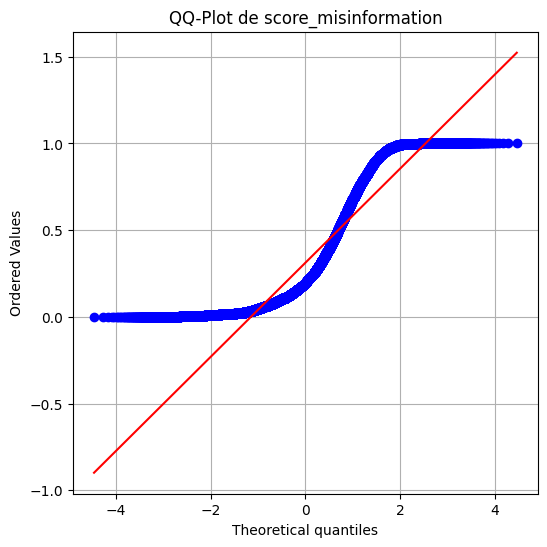

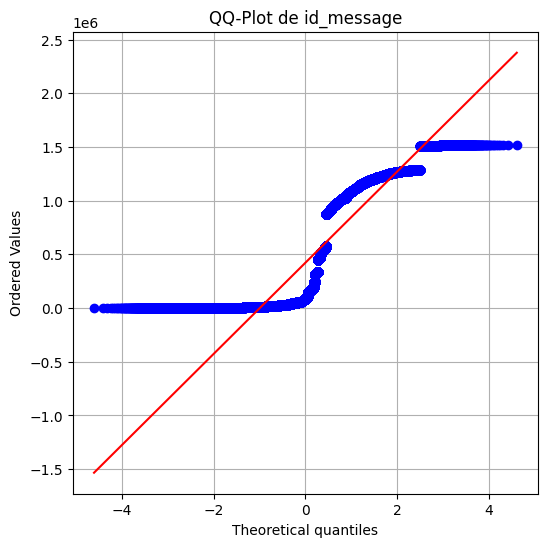

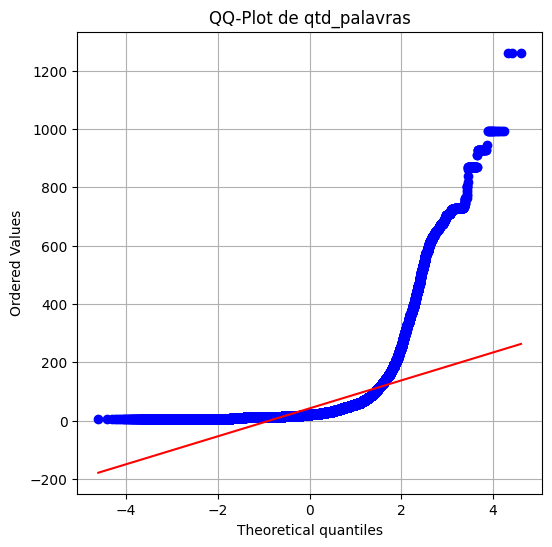

In [ ]:
for coluna in atributos_numericos:
    serie = df_sem_mensagens_curtas[coluna].dropna()
    
    plt.figure(figsize=(6, 6))
    stats.probplot(serie, dist="norm", plot=plt)
    plt.title(f'QQ-Plot de {coluna}')
    plt.grid(True)
    plt.show()

#### 6. **Teste de Normalidade**

Para avaliar a adequação dos dados à **distribuição normal**, realizamos o **Teste de Shapiro-Wilk** em cada uma das colunas numéricas do dataset. Esse teste é amplamente recomendado para amostras pequenas e médias, mas pode ser utilizado como referência mesmo em datasets maiores, com as devidas cautelas quanto à interpretação.

**Justificativa da Escolha:**

- O teste de **Shapiro-Wilk** avalia a hipótese nula de que os dados seguem uma distribuição normal.
- **Valor-p > 0.05**: não rejeitamos a hipótese nula; os dados podem ser considerados normalmente distribuídos.
- **Valor-p ≤ 0.05**: rejeitamos a hipótese nula; os dados provavelmente não seguem uma distribuição normal.

In [ ]:
# Seleção das colunas numéricas
atributos_numericos = df_sem_mensagens_curtas.select_dtypes(include=['int64', 'float64']).columns

# Lista para armazenar os resultados
resultados_normalidade = []

# Loop pelas colunas numéricas
for coluna in atributos_numericos:
    serie = df_sem_mensagens_curtas[coluna].dropna()
    
    # o Shapiro-Wilk possui limitação de tamanho (máx ~5000 observações)
    # Portanto, fazemos um sample se for necessário
    if len(serie) > 5000:
        serie = serie.sample(5000, random_state=42)
    
    stat, p = shapiro(serie)
    
    resultado = {
        'Atributo': coluna,
        'Estatística W': round(stat, 4),
        'Valor-p': round(p, 4),
        'Normal?': 'Sim' if p > 0.05 else 'Não'
    }
    
    resultados_normalidade.append(resultado)

# Criação do DataFrame com os resultados
df_normalidade = pd.DataFrame(resultados_normalidade)

# Exibição formatada
display(df_normalidade.sort_values(by='Atributo'))


c:\Users\esthe\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Atributo  Estatística W  Valor-p Normal?
0       dataset_info_id         1.0000      1.0     Sim
3            id_message         0.7643      0.0     Não
4          qtd_palavras         0.4265      0.0     Não
2  score_misinformation         0.8541      0.0     Não
1       score_sentiment         0.9626      0.0     Não

Complementando o Teste de Shapiro-Wilk, aplicamos o **Teste de Kolmogorov-Smirnov (K-S)** para avaliar a aderência das distribuições numéricas à distribuição normal.

**Por que utilizar o Teste K-S?**

- O **Teste de Kolmogorov-Smirnov** compara a distribuição empírica dos dados com uma distribuição teórica, neste caso, a **distribuição normal padrão**.
- É especialmente útil para **grandes amostras**, pois o Shapiro-Wilk apresenta limitações para conjuntos com mais de 5000 observações.
- Critério de decisão:
  - **Valor-p > 0.05**: não rejeitamos a hipótese nula; a distribuição dos dados não difere significativamente da normal.
  - **Valor-p ≤ 0.05**: rejeitamos a hipótese nula; os dados não seguem uma distribuição normal.

**Nota Técnica:**  
O teste K-S é sensível à média e ao desvio padrão, então, para uma aplicação adequada, os dados foram **padronizados** (z-score) antes do teste.

In [ ]:
# Seleção das colunas numéricas
atributos_numericos = df_sem_mensagens_curtas.select_dtypes(include=['int64', 'float64']).columns

# Lista para armazenar os resultados
resultados_ks = []

# Loop pelas colunas numéricas
for coluna in atributos_numericos:
    serie = df_sem_mensagens_curtas[coluna].dropna()
    
    # Padronização (z-score)
    serie_padronizada = zscore(serie)
    
    # Aplicação do teste K-S
    stat, p = kstest(serie_padronizada, 'norm')
    
    resultado = {
        'Atributo': coluna,
        'Estatística D': round(stat, 4),
        'Valor-p': round(p, 4),
        'Normal?': 'Sim' if p > 0.05 else 'Não'
    }
    
    resultados_ks.append(resultado)

# Criação do DataFrame com os resultados
df_ks = pd.DataFrame(resultados_ks)

# Exibição formatada
display(df_ks.sort_values(by='Atributo'))

C:\Users\esthe\AppData\Local\Temp\ipykernel_23144\3626569203.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  serie_padronizada = zscore(serie)


Atributo  Estatística D  Valor-p Normal?
0       dataset_info_id            NaN      NaN     Não
3            id_message         0.2639      0.0     Não
4          qtd_palavras         0.3085      0.0     Não
2  score_misinformation         0.1557      0.0     Não
1       score_sentiment         0.1214      0.0     Não

#### 7. **Best Fit Distribution (usando diferentes métodos)**

**Motivações para essa abordagem:**
- Permite modelar fenômenos com mais precisão.
- Essencial para simulações, geração de dados sintéticos ou aplicação de modelos probabilísticos.
- Auxilia na escolha de testes estatísticos mais adequados.

**Metodologia aplicada:**
- Seleção de diversas distribuições clássicas: **Normal**, **Exponencial**, **Gamma**, **Beta**.
- Ajuste dos parâmetros utilizando o método de **Maximum Likelihood Estimation (MLE)**, via `scipy.stats`.
- Cálculo de métricas de aderência, como:
  - **Kolmogorov-Smirnov Statistic** (distância máxima entre CDFs).
  - **Akaike Information Criterion (AIC)** (opcional para comparação mais robusta).

**Importante:**  
- Apenas variáveis **contínuas** foram consideradas.  
- Para variáveis que representam **IDs** ou com distribuição **fortemente discreta**, o ajuste não foi consideradoi.


Melhor ajuste para: score_sentiment


Distribuição  KS Estatística  KS p-valor  \
3         beta          0.1181         0.0   
2        gamma          0.1190         0.0   
0         norm          0.1214         0.0   
1        expon          0.2476         0.0   

                                          Parâmetros  
3  (1.225944158103615, 1.1806490456169234, -1.001...  
2  (2345.12815270133, -25.63685628890309, 0.01094...  
0         (0.022024824975901948, 0.5297235689559867)  
1                         (-1.0, 1.0220248249759019)

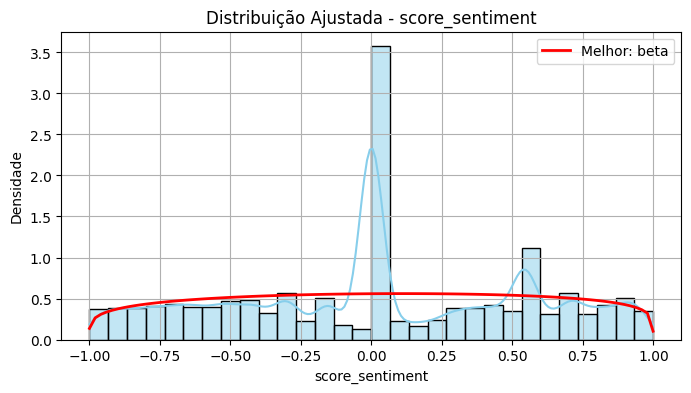

c:\Users\esthe\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)



Melhor ajuste para: score_misinformation


Distribuição  KS Estatística  KS p-valor  \
2        gamma          0.0467         0.0   
1        expon          0.0487         0.0   
3         beta          0.1039         0.0   
0         norm          0.1557         0.0   

                                          Parâmetros  
2  (0.9560778266350399, 3.2731487152999994e-06, 0...  
1             (3.2731487153e-06, 0.3122595196278037)  
3  (0.5970920868525846, 1.1260199279122054, 3.273...  
0         (0.31226279277651897, 0.29370207404974585)

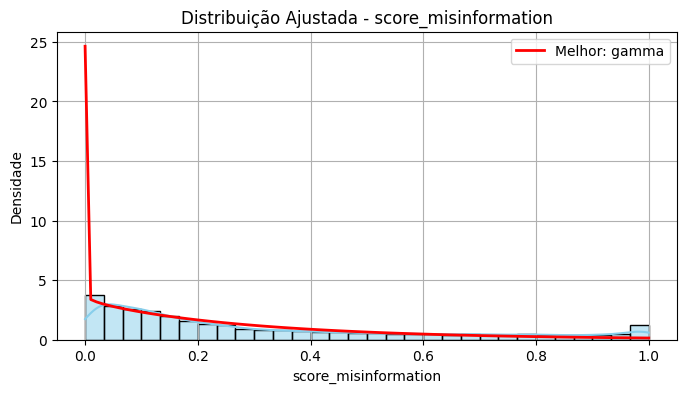

In [20]:
# Seleção das colunas numéricas contínuas
atributos_continuos = ['score_sentiment', 'score_misinformation']

# Lista de distribuições candidatas
distribuicoes = {
    'norm': stats.norm,
    'expon': stats.expon,
    'gamma': stats.gamma,
    'beta': stats.beta
}

# Loop pelas colunas
for coluna in atributos_continuos:
    serie = df_sem_mensagens_curtas[coluna].dropna()
    
    resultados = []
    
    # Ajuste de cada distribuição
    for nome, dist in distribuicoes.items():
        try:
            params = dist.fit(serie)
            ks_stat, ks_p = stats.kstest(serie, nome, args=params)
            resultados.append({
                'Distribuição': nome,
                'KS Estatística': round(ks_stat, 4),
                'KS p-valor': round(ks_p, 4),
                'Parâmetros': params
            })
        except Exception as e:
            print(f"Erro ao ajustar {nome} para {coluna}: {e}")

    # Resultado em DataFrame
    df_resultados = pd.DataFrame(resultados).sort_values(by='KS Estatística')
    print(f"\nMelhor ajuste para: {coluna}")
    display(df_resultados)

    # Plotagem do histograma com densidade
    plt.figure(figsize=(8, 4))
    sns.histplot(serie, bins=30, kde=True, stat='density', color='skyblue')
    
    # Sobreposição da melhor distribuição
    melhor = df_resultados.iloc[0]
    dist_name = melhor['Distribuição']
    params = melhor['Parâmetros']
    
    x = np.linspace(serie.min(), serie.max(), 100)
    pdf = distribuicoes[dist_name].pdf(x, *params)
    plt.plot(x, pdf, 'r-', lw=2, label=f'Melhor: {dist_name}')
    
    plt.title(f'Distribuição Ajustada - {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True)
    plt.show()


---

### **(f)** Para cada par de atributos numéricos apresente: 

#### 1. **O Coeficiente de Correlação apropriado**

**Metodologia:**
- Utilizando dois tipos de correlação:
  - **Pearson**: ideal para verificar relações lineares entre variáveis normalmente distribuídas.
  - **Spearman**: robusto a distribuições não-normais e outliers, avalia relações monotônicas.

**Critérios de interpretação:**
- Correlação forte: > 0.7 ou < -0.7.
- Correlação moderada: entre 0.3 e 0.7 (positivo ou negativo).
- Correlação fraca: entre -0.3 e 0.3.

O resultado inclui também o **p-valor** do Spearman, que indica a significância estatística da correlação.

In [31]:
# Seleção das colunas numéricas
atributos_numericos = df_sem_mensagens_curtas.select_dtypes(include=['int64', 'float64']).columns

# Loop para cálculo das correlações
for i in range(len(atributos_numericos)):
    for j in range(i+1, len(atributos_numericos)):
        col1 = atributos_numericos[i]
        col2 = atributos_numericos[j]
        
        dados = df_sem_mensagens_curtas[[col1, col2]].dropna()

        # Verifica se ambos os vetores têm mais de um valor único
        if dados[col1].nunique() <= 1 or dados[col2].nunique() <= 1:
            print(f"\nPar: {col1} vs {col2}")
            print("Correlação não calculada: uma das variáveis é constante.")
            continue

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Correlação de Pearson
            pearson_corr = dados[col1].corr(dados[col2], method='pearson')
            
            # Correlação de Spearman
            spearman_corr, spearman_p = spearmanr(dados[col1], dados[col2])

        # Tratamento de NaN na correlação
        if pd.isna(pearson_corr) or pd.isna(spearman_corr):
            print(f"\nPar: {col1} vs {col2}")
            print("Correlação não definida devido a dados constantes ou insuficientes.")
        else:
            print(f"\nPar: {col1} vs {col2}")
            print(f"Pearson: {pearson_corr:.4f}")
            print(f"Spearman: {spearman_corr:.4f} (p-valor: {spearman_p:.4g})")


Par: dataset_info_id vs score_sentiment
Correlação não calculada: uma das variáveis é constante.

Par: dataset_info_id vs score_misinformation
Correlação não calculada: uma das variáveis é constante.

Par: dataset_info_id vs id_message
Correlação não calculada: uma das variáveis é constante.

Par: dataset_info_id vs qtd_palavras
Correlação não calculada: uma das variáveis é constante.

Par: score_sentiment vs score_misinformation
Pearson: -0.3562
Spearman: -0.3885 (p-valor: 0)

Par: score_sentiment vs id_message
Pearson: -0.1084
Spearman: -0.1580 (p-valor: 0)

Par: score_sentiment vs qtd_palavras
Pearson: -0.0955
Spearman: -0.0166 (p-valor: 3.111e-22)

Par: score_misinformation vs id_message
Pearson: 0.1732
Spearman: 0.2452 (p-valor: 0)

Par: score_misinformation vs qtd_palavras
Pearson: 0.2857
Spearman: 0.1815 (p-valor: 0)

Par: id_message vs qtd_palavras
Pearson: -0.0119
Spearman: -0.0526 (p-valor: 9.872e-207)


#### 2. **Um Gráfico de Dispersão**

- Essencial para verificar padrões visuais, como tendências lineares ou não-lineares.
- Facilita a identificação de **outliers** e **clusters**.
- Complementa a análise estatística, tornando-a mais interpretável.

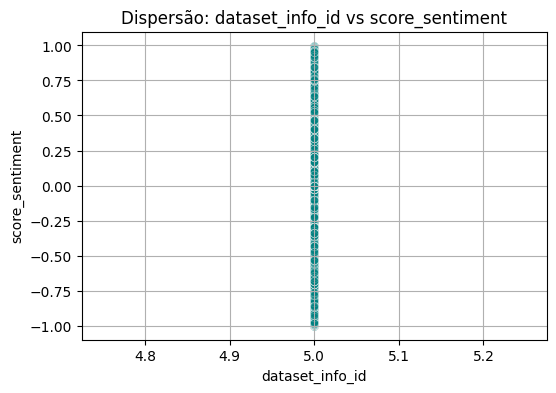

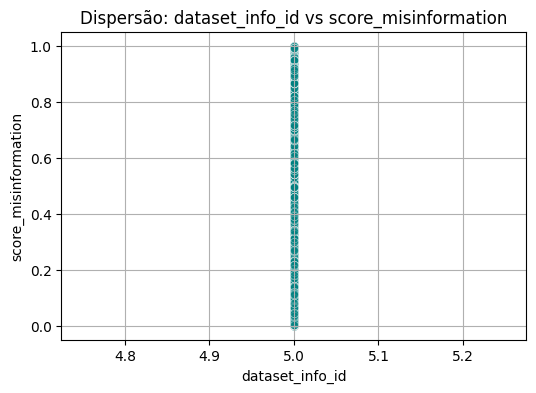

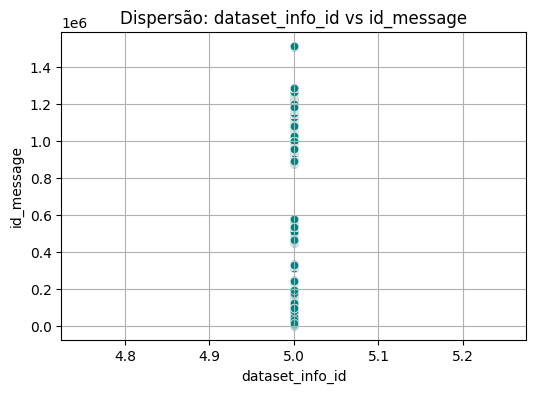

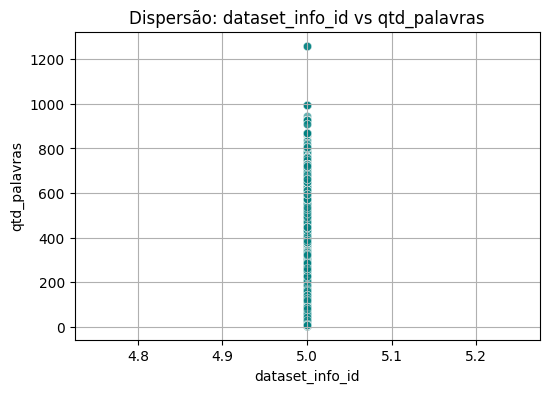

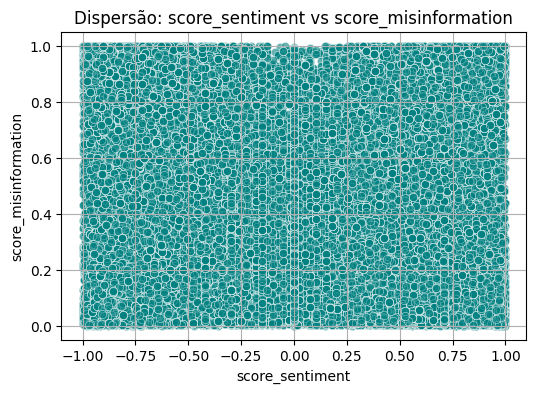

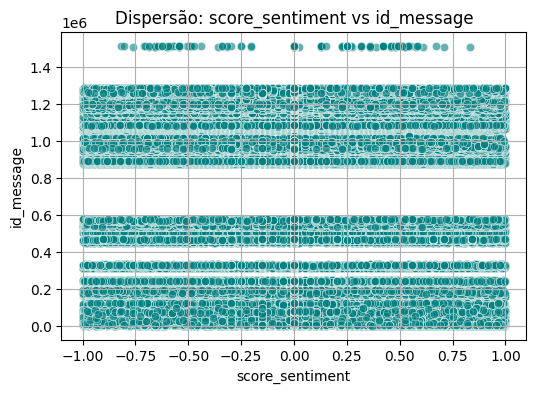

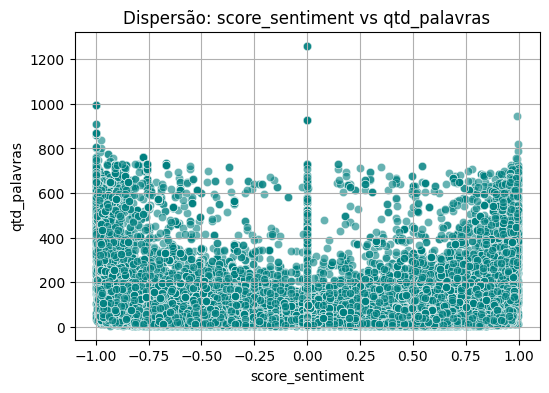

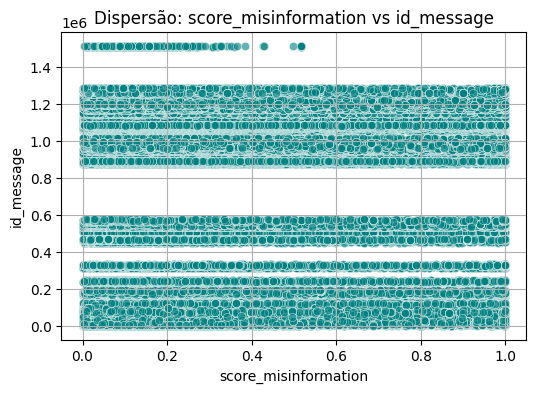

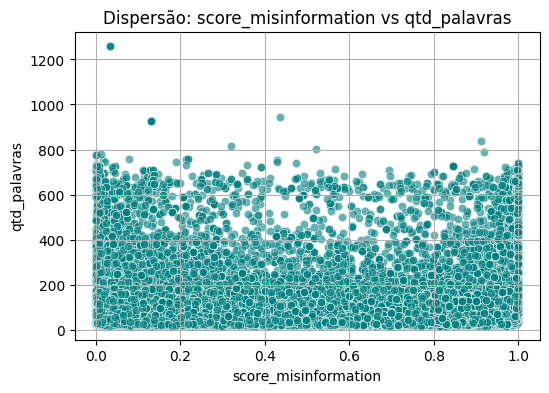

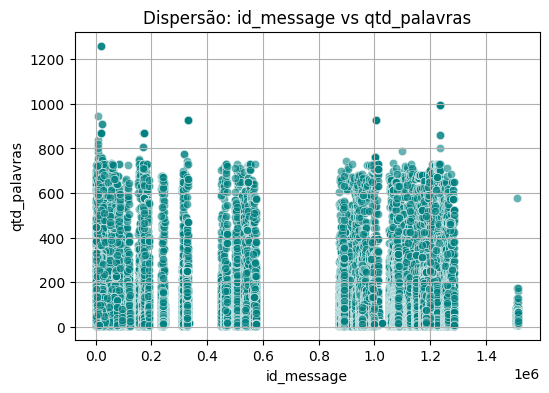

In [29]:
# Loop para plotar os gráficos de dispersão
for i in range(len(atributos_numericos)):
    for j in range(i+1, len(atributos_numericos)):
        col1 = atributos_numericos[i]
        col2 = atributos_numericos[j]
        
        dados = df_sem_mensagens_curtas[[col1, col2]].dropna()

        # Gráfico de Dispersão
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=dados, x=col1, y=col2, alpha=0.6, color='teal')
        plt.title(f'Dispersão: {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(True)
        plt.show()

---

### **(g)** Para cada par de atributos numéricos apresente: O resultado do método V de Cramer 

Para avaliar a **força de associação** entre duas variáveis categóricas, utilizamos o **V de Cramer**. Esse coeficiente é baseado no teste qui-quadrado e varia de 0 (nenhuma associação) até 1 (associação perfeita).

**Etapas:**
1. Selecionei as colunas categóricas.
2. Criei uma tabela de contingência para cada par.
3. Apliquei o teste qui-quadrado.
4. Calculei o V de Cramer.

**Importante:** O V de Cramer ajusta o qui-quadrado conforme o tamanho da amostra e as dimensões da tabela, evitando inflar o valor em tabelas grandes.

In [ ]:
# Função para calcular o V de Cramer
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt((chi2 / n) / min_dim)

# Seleção das colunas categóricas
atributos_categoricos = [
    col for col in df_sem_mensagens_curtas.select_dtypes(include=['object', 'bool']).columns
    if df_sem_mensagens_curtas[col].nunique() <= 50
] # Necessário para não explodir a memória

# Loop sobre cada par de atributos categóricos
for i in range(len(atributos_categoricos)):
    for j in range(i + 1, len(atributos_categoricos)):
        col1 = atributos_categoricos[i]
        col2 = atributos_categoricos[j]
        
        # Tabela de contingência
        tabela_contingencia = pd.crosstab(df_sem_mensagens_curtas[col1], df_sem_mensagens_curtas[col2])
        
        # Verifica se a tabela não é trivial
        if tabela_contingencia.shape[0] < 2 or tabela_contingencia.shape[1] < 2:
            print(f"\nPar: {col1} vs {col2}")
            print("V de Cramer não calculado: tabela de contingência trivial.")
            continue
        
        # Cálculo do V de Cramer
        v = cramers_v(tabela_contingencia)
        
        print(f"\nPar: {col1} vs {col2}")
        print(f"V de Cramer: {v:.4f}")



Par: media_type vs has_media
V de Cramer não calculado: tabela de contingência trivial.

Par: media_type vs has_media_url
V de Cramer: 0.6797

Par: media_type vs trava_zap
V de Cramer não calculado: tabela de contingência trivial.

Par: media_type vs message_type
V de Cramer: 0.9196

Par: media_type vs messenger
V de Cramer não calculado: tabela de contingência trivial.

Par: has_media vs has_media_url
V de Cramer: 0.4845

Par: has_media vs trava_zap
V de Cramer não calculado: tabela de contingência trivial.

Par: has_media vs message_type
V de Cramer: 1.0000

Par: has_media vs messenger
V de Cramer não calculado: tabela de contingência trivial.

Par: has_media_url vs trava_zap
V de Cramer não calculado: tabela de contingência trivial.

Par: has_media_url vs message_type
V de Cramer: 0.6834

Par: has_media_url vs messenger
V de Cramer não calculado: tabela de contingência trivial.

Par: trava_zap vs message_type
V de Cramer não calculado: tabela de contingência trivial.

Par: trava_za

---

### **(h)** Crie uma visualização (gráfico) para apresentar: 

#### 1. **As quantidades de grupos, usuários e mensagens**

Para criar este gráfico, comecei calculando a quantidade única de grupos (`id_group_anonymous`), a quantidade única de usários (`id_member_anonymous`) e o número total de linhas, que representam o total de mensagens.

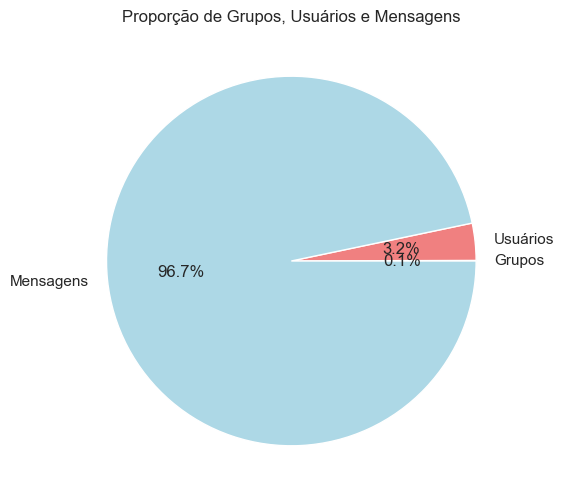

Quantidades: {'Grupos': 177, 'Usuários': 11366, 'Mensagens': 339286}


In [46]:
# Quantidades corretas
quantidades = {
    'Grupos': df_sem_mensagens_curtas['id_group_anonymous'].nunique(),
    'Usuários': df_sem_mensagens_curtas['id_member_anonymous'].nunique(),
    'Mensagens': df_sem_mensagens_curtas.shape[0]
}

# Visualização com pizza
plt.figure(figsize=(6,6))
plt.pie(
    quantidades.values(),
    labels=quantidades.keys(),
    autopct='%1.1f%%',
    colors=['skyblue', 'lightcoral', 'lightblue']  
)

plt.title('Proporção de Grupos, Usuários e Mensagens')
plt.show()

# Print também para ver as quantidades
print("Quantidades:", quantidades)

#### 2. **A quantidade de mensagens que possuem apenas texto X mídia**

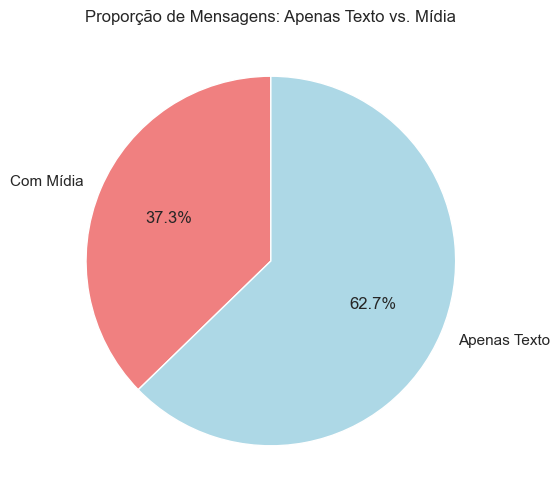

Quantidades: {'Com Mídia': 126431, 'Apenas Texto': 212855}


In [44]:
# Contagem de mensagens com e sem mídia
com_midia = df_sem_mensagens_curtas['has_media'].sum()
sem_midia = (~df_sem_mensagens_curtas['has_media']).sum()

# Dicionário com as quantidades
quantidades_midia = {
    'Com Mídia': com_midia,
    'Apenas Texto': sem_midia
}

# Gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(quantidades_midia.values(), labels=quantidades_midia.keys(),
        autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])

plt.title('Proporção de Mensagens: Apenas Texto vs. Mídia')
plt.show()

# Print também para conferência
print("Quantidades:", quantidades_midia)


#### 3. **Quantidade de mensagens por tipo de mídia (jpg, mp4 etc)**

C:\Users\esthe\AppData\Local\Temp\ipykernel_3008\2379714968.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


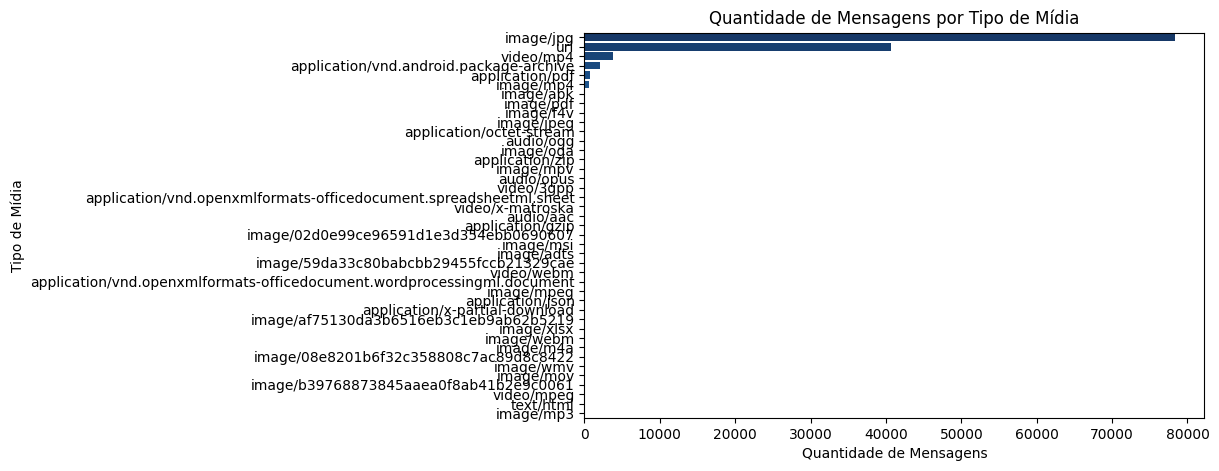

Quantidade por tipo de mídia:
media_type
image/jpg                                                                  78330
url                                                                        40625
video/mp4                                                                   3786
application/vnd.android.package-archive                                     2051
application/pdf                                                              715
image/mp4                                                                    573
image/apk                                                                    116
image/pdf                                                                     67
image/f4v                                                                     32
image/jpeg                                                                    27
application/octet-stream                                                      17
audio/ogg                                                           

In [8]:
# Primeiro, conto a quantidade de mensagens por tipo de mídia
quant_midia = df_sem_mensagens_curtas['media_type'].value_counts()

# Criação do gráfico de barras horizontais
plt.figure(figsize=(8, 5))
sns.barplot(
    x=quant_midia.values, 
    y=quant_midia.index, 
    palette='Blues_r'  # Mantendo tons de azul, do mais claro ao mais escuro
)

plt.xlabel('Quantidade de Mensagens')
plt.ylabel('Tipo de Mídia')
plt.title('Quantidade de Mensagens por Tipo de Mídia')

plt.show()

# Print para visualizar os valores exatos
print("Quantidade por tipo de mídia:")
print(quant_midia)

#### 4. **A relação entre a quantidade de mensagens e a quantidade de palavras presente nas mensagens**

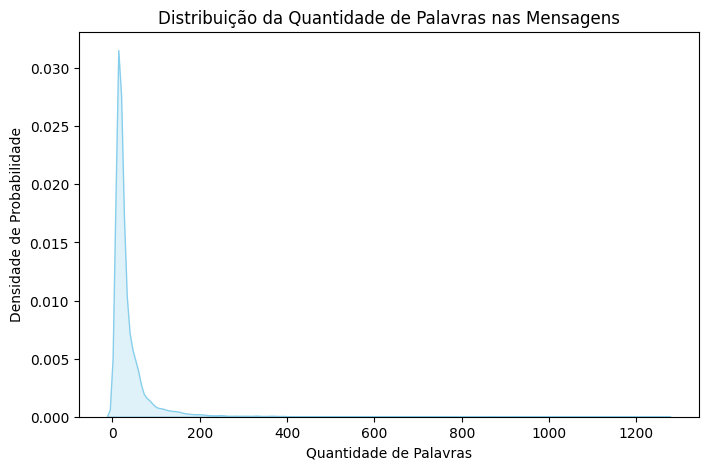


Estatísticas descritivas da quantidade de palavras:

→ Total de mensagens analisadas: 339286
→ Média de palavras por mensagem: 42.03
→ Mediana (50%): 20.0
→ Desvio padrão: 74.05
→ Valor mínimo: 5.0
→ 1º Quartil (25%): 14.0
→ 3º Quartil (75%): 40.0
→ Valor máximo: 1261.0
→ Valor mais frequente (moda): 15


In [12]:
# Plot do gráfico de densidade
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_sem_mensagens_curtas, 
    x='qtd_palavras', 
    fill=True, 
    color='skyblue'
)

plt.xlabel('Quantidade de Palavras')
plt.ylabel('Densidade de Probabilidade')
plt.title('Distribuição da Quantidade de Palavras nas Mensagens')

plt.show()

# Estatísticas descritivas formatadas
descricao = df_sem_mensagens_curtas['qtd_palavras'].describe()
moda = df_sem_mensagens_curtas['qtd_palavras'].mode()[0]

# Printando dados para melhor interpretação
print("\nEstatísticas descritivas da quantidade de palavras:\n")
print(f"→ Total de mensagens analisadas: {int(descricao['count'])}")
print(f"→ Média de palavras por mensagem: {descricao['mean']:.2f}")
print(f"→ Mediana (50%): {descricao['50%']}")
print(f"→ Desvio padrão: {descricao['std']:.2f}")
print(f"→ Valor mínimo: {descricao['min']}")
print(f"→ 1º Quartil (25%): {descricao['25%']}")
print(f"→ 3º Quartil (75%): {descricao['75%']}")
print(f"→ Valor máximo: {descricao['max']}")
print(f"→ Valor mais frequente (moda): {moda}")

#### 10. **As 30 URLs que mais se repetem (mais compartilhadas)**

C:\Users\esthe\AppData\Local\Temp\ipykernel_3008\2491536251.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


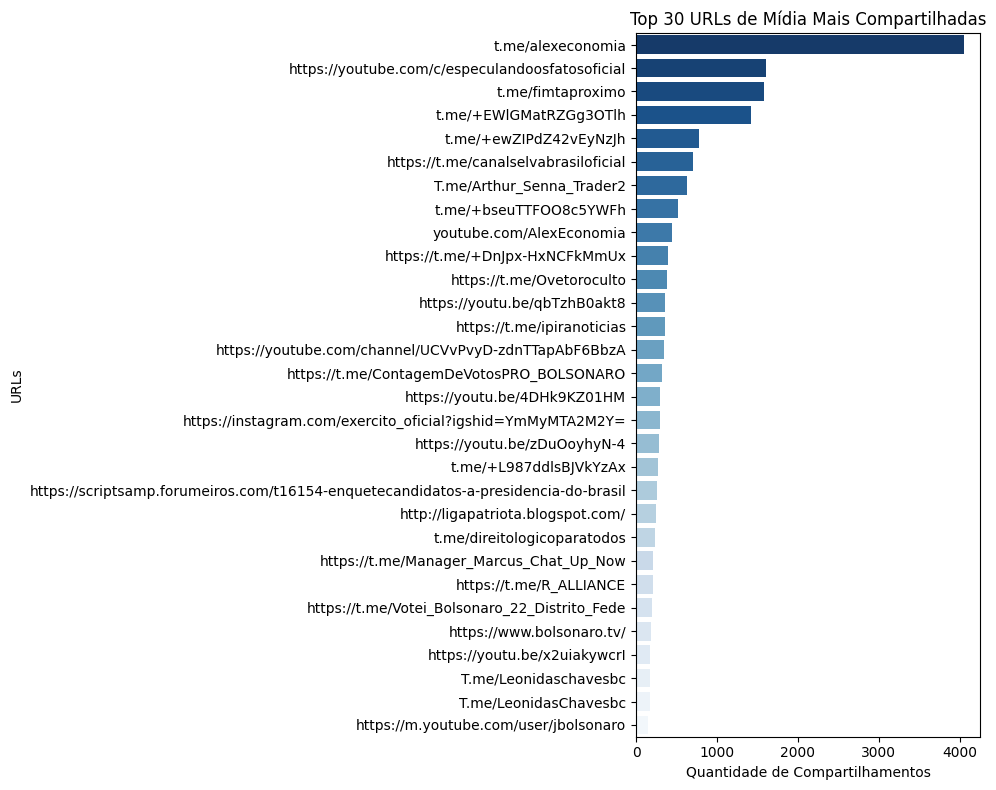

Top 30 URLs mais compartilhadas:
media_url
t.me/alexeconomia                                                                     4046
https://youtube.com/c/especulandoosfatosoficial                                       1607
t.me/fimtaproximo                                                                     1579
t.me/+EWlGMatRZGg3OTlh                                                                1419
t.me/+ewZIPdZ42vEyNzJh                                                                 772
https://t.me/canalselvabrasiloficial                                                   708
T.me/Arthur_Senna_Trader2                                                              631
t.me/+bseuTTFOO8c5YWFh                                                                 515
youtube.com/AlexEconomia                                                               445
https://t.me/+DnJpx-HxNCFkMmUx                                                         390
https://t.me/Ovetoroculto                      

In [14]:
# Contar as URLs mais frequentes
urls_mais_compartilhadas = df_sem_mensagens_curtas['media_url'].value_counts().head(30)

# Criar gráfico de barras horizontais
plt.figure(figsize=(10, 8))
sns.barplot(
    y=urls_mais_compartilhadas.index,  # URLs no eixo Y
    x=urls_mais_compartilhadas.values, # Contagem no eixo X
    palette='Blues_r'                  # Paleta de cores em tons de azul
)

plt.xlabel('Quantidade de Compartilhamentos')
plt.ylabel('URLs')
plt.title('Top 30 URLs de Mídia Mais Compartilhadas')
plt.tight_layout()
plt.show()

# Exibir as 30 URLs mais compartilhadas
print("Top 30 URLs mais compartilhadas:")
print(urls_mais_compartilhadas)

#### 11. **Os 30 domínios que mais se repetem (mais compartilhados)**

Primeiro, fiz a extração do domínio de cada media_url, depois:
1. Contar quantos compartilhamentos cada domínio teve (URL count).
2. Contar quantas URLs únicas cada domínio possui (Number of unique URLs).
3. Contar quantos usuários distintos compartilharam cada domínio (Number of users).

> Seguindo a ideia de visualização disponibilizada pelo professor

In [29]:
# Extrair domínio das URLs
df_sem_mensagens_curtas['url_domain'] = df_sem_mensagens_curtas['media_url'].dropna().apply(lambda x: urlparse(x).netloc)

# Filtrar apenas as linhas que possuem media_url
df_urls = df_sem_mensagens_curtas.dropna(subset=['media_url'])

# Agrupar e calcular as métricas
dominio_stats = df_urls.groupby('url_domain').agg(
    URL_count=('media_url', 'count'),
    Number_of_unique_URLs=('media_url', 'nunique'),
    Number_of_users=('id_member_anonymous', 'nunique')
).reset_index()

# Ordenar pelos domínios mais compartilhados
top_dominios = dominio_stats.sort_values(by='URL_count', ascending=False).head(30)

# Renomear colunas para apresentar na tabela
top_dominios = top_dominios.rename(columns={
    'url_domain': 'URL Domain',
    'URL_count': 'URL count',
    'Number_of_unique_URLs': 'Number of unique URLs',
    'Number_of_users': 'Number of users'
})

# Criar tabela estilizada com cores alternadas
styled_table = top_dominios.style \
    .set_caption("Top 30 Domínios Mais Compartilhados") \
    .set_table_styles(
        [
            {'selector': 'th', 
             'props': [('background-color', '#4F81BD'), 
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2' 
                   for i in range(len(x))], 
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibir a tabela estilizada
styled_table

#### 12. **Os 30 usuários mais ativos**

In [30]:
# Aqui estou criando a tabela dos 30 usuários mais ativos, ordenando pelo número de mensagens.
usuarios_ativos = df_sem_mensagens_curtas.groupby('id_member_anonymous').agg(
    Message_count=('id_message', 'count')
).reset_index()

top_usuarios = usuarios_ativos.sort_values(by='Message_count', ascending=False).head(30)

# Renomeando para deixar mais legível
top_usuarios = top_usuarios.rename(columns={
    'id_member_anonymous': 'User ID',
    'Message_count': 'Number of Messages'
})

# Criando a tabela estilizada que nem no item anterior
styled_table_usuarios = top_usuarios.style \
    .set_caption("Top 30 Usuários Mais Ativos") \
    .set_table_styles(
        [
            {'selector': 'th', 
             'props': [('background-color', '#4F81BD'), 
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2' 
                   for i in range(len(x))], 
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibindo a tabela estilizada
styled_table_usuarios

#### 13. **Relação entre quantidade de mensagens contendo somente texto e mensagens contendo mídia dos usuários mais ativos**

Primeiro, eu criei uma tabela agregada que conta o total de mensagens, mensagens apenas de texto (sem mídia) e mensagens com mídia para cada usuário, para fazer isso usei o groupby no ID do usuário e funções de agregação.

Depois, filtrei apenas os 30 usuários mais ativos, ordenando pelo total de mensagens. Para preparar os dados para o gráfico de barras agrupadas, precisei "derreter" (`melt`) o dataframe, transformando as colunas de texto e mídia em linhas, com uma coluna indicando o tipo de mensagem.

No gráfico em si, usei o seaborn para criar as barras agrupadas, com cores que seguem o padrão do código anterior. Adicionei títulos, labels e ajustes de layout para deixar a visualização mais clara e profissional.

**Algumas decisões importantes que tomei:**
- Mantive os IDs dos usuários no eixo x, mas poderia ter usado números sequenciais se quisesse mais simplicidade
- Adicionei grid lines para facilitar a leitura dos valores
- Ajustei automaticamente o limite do eixo y para acomodar o usuário com mais mensagens

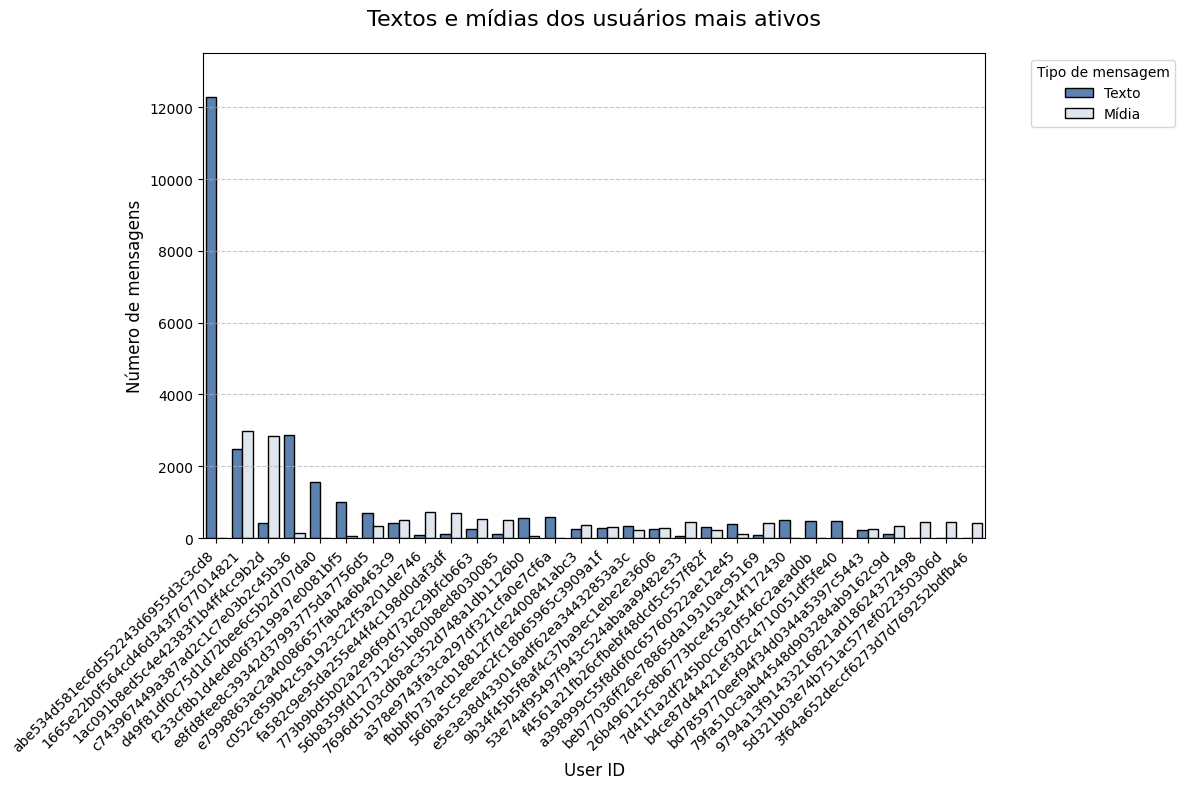

In [33]:
# Primeiro, criar uma tabela com a contagem de mensagens de texto e com mídia por usuário
df_contagem = df_sem_mensagens_curtas.groupby('id_member_anonymous').agg(
    total_messages=('id_message', 'count'),
    text_messages=('has_media', lambda x: (x == False).sum()),  # Mensagens sem mídia
    media_messages=('has_media', lambda x: (x == True).sum())   # Mensagens com mídia
).reset_index()

# Filtrando os 30 usuários mais ativos (com base no total de mensagens) -- é possível alterar esse filtro
top_usuarios = df_contagem.sort_values('total_messages', ascending=False).head(30)

# Preparando os dados para o gráfico de barras
top_usuarios_melted = top_usuarios.melt(
    id_vars=['id_member_anonymous', 'total_messages'], 
    value_vars=['text_messages', 'media_messages'],
    var_name='message_type', 
    value_name='count'
)

# Substituindo os nomes para ficarem mais legíveis
top_usuarios_melted['message_type'] = top_usuarios_melted['message_type'].replace({
    'text_messages': 'Texto',
    'media_messages': 'Mídia'
})

# Ordenando os usuários pelo total de mensagens
top_usuarios_melted = top_usuarios_melted.sort_values('total_messages', ascending=False)

# Criando o gráfico
plt.figure(figsize=(12, 8))
colors = {'Texto': '#4F81BD', 'Mídia': '#DCE6F1'}

# Plotando as barras
sns.barplot(
    data=top_usuarios_melted,
    x='id_member_anonymous',
    y='count',
    hue='message_type',
    palette=colors,
    edgecolor='black'
)

# Ajustando o layout
plt.title('Textos e mídias dos usuários mais ativos', fontsize=16, pad=20)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Número de mensagens', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de mensagem', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adicionando linhas de grade para melhor leitura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustando os limites do eixo y para melhor visualização
plt.ylim(0, top_usuarios['total_messages'].max() * 1.1)

plt.tight_layout()
plt.show()

#### 14. **Top 30 Usuários que Mais Compartilharam Texto**

Para analisar os usuários que mais compartilharam texto, primeiro filtrei apenas as mensagens sem mídia (`has_media == False`). Depois agrupei por usuário e contei quantas mensagens de texto cada um enviou, calculando também a média de palavras por mensagem como métrica adicional.

In [36]:
# Filtrar apenas mensagens de texto (sem mídia)
df_textos = df_sem_mensagens_curtas[df_sem_mensagens_curtas['has_media'] == False]

# Agregar por usuário e contar mensagens de texto
top_textos = df_textos.groupby('id_member_anonymous').agg(
    Mensagens_Texto=('id_message', 'count'),
    Media_Palavras=('qtd_palavras', 'mean')
).reset_index()

# Pegar os 30 top e ordenar
top_30_textos = top_textos.sort_values('Mensagens_Texto', ascending=False).head(30)

# Criando a tabela estilizada com o mesmo padrão
styled_table_textos = top_30_textos.rename(columns={
    'id_member_anonymous': 'ID_Usuário',
    'Mensagens_Texto': 'Mensagens de Texto',
    'Media_Palavras': 'Média Palavras'
}).style \
    .set_caption("Top 30 Usuários que Mais Compartilharam Texto") \
    .set_table_styles(
        [
            {'selector': 'th', 
             'props': [('background-color', '#4F81BD'), 
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2' 
                   for i in range(len(x))], 
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'}) \
    .format({'Média Palavras': '{:.1f}'})

# Exibindo a tabela estilizada
styled_table_textos

#### 15. **Os 30 usuários que mais compartilharam mídias**

In [37]:
# Filtrar apenas mensagens com mídia
df_medias = df_sem_mensagens_curtas[df_sem_mensagens_curtas['has_media'] == True]

# Agregar por usuário e contar mensagens com mídia
top_medias = df_medias.groupby('id_member_anonymous').agg(
    Mensagens_Midia=('id_message', 'count'),
    Tipos_Midia=('media_type', lambda x: x.mode()[0] if not x.empty else 'N/A')
).reset_index()

# Pegar os 30 top e ordenar
top_30_medias = top_medias.sort_values('Mensagens_Midia', ascending=False).head(30)

styled_table_medias = top_30_medias.rename(columns={
    'id_member_anonymous': 'ID_Usuário',
    'Mensagens_Midia': 'Mensagens com Mídia',
    'Tipos_Midia': 'Tipo de Mídia Mais Enviado'
}).style \
    .set_caption("Top 30 Usuários que Mais Compartilharam Mídias") \
    .set_table_styles(
        [
            {'selector': 'th', 
             'props': [('background-color', '#4F81BD'), 
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2' 
                   for i in range(len(x))], 
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibindo a tabela estilizada
styled_table_medias

#### 16. **As 30 mensagens mais compartilhadas**

In [41]:
# Como não temos uma coluna direta com o número de compartilhamentos, estou contando quantas vezes cada 'id_message' aparece.
mensagens_compartilhadas = df_sem_mensagens_curtas.groupby('id_message').agg(
    Share_count=('id_message', 'count'),
    Texto=('text_content_anonymous', 'first')  # Pegando o conteúdo da mensagem para referência.
).reset_index()

top_mensagens = mensagens_compartilhadas.sort_values(by='Share_count', ascending=False).head(30)

# Renomeando as colunas para deixar a tabela mais legível.
top_mensagens = top_mensagens.rename(columns={
    'id_message': 'Message ID',
    'Share_count': 'Number of Shares',
    'Texto': 'Message Content'
})

styled_table_mensagens = top_mensagens.style \
    .set_caption("Top 30 Mensagens Mais Compartilhadas") \
    .set_table_styles(
        [
            {'selector': 'th',
             'props': [('background-color', '#4F81BD'),
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2'
                   for i in range(len(x))],
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibindo a tabela estilizada.
styled_table_mensagens


In [42]:
# Aqui estou filtrando o DataFrame para manter apenas as mensagens não nulas e não vazias,
# garantindo que só mensagens relevantes entrem na análise.

mensagens_validas = df_sem_mensagens_curtas[
    df_sem_mensagens_curtas['text_content_anonymous'].notnull() &
    (df_sem_mensagens_curtas['text_content_anonymous'].str.strip() != '')
]

# Agora estou agrupando pelo conteúdo da mensagem, contando quantas vezes cada uma aparece,
# como uma forma de medir o quanto ela foi compartilhada.

mensagens_mais_compartilhadas = mensagens_validas.groupby('text_content_anonymous').agg(
    total_compartilhamentos=('text_content_anonymous', 'count')
).reset_index()

# Ordeno as mensagens pelo total de compartilhamentos, de forma decrescente,
# e pego apenas as 30 mais compartilhadas.

top_mensagens = mensagens_mais_compartilhadas.sort_values(
    by='total_compartilhamentos', ascending=False
).head(30)

# Para deixar mais legível, renomeio as colunas.

top_mensagens = top_mensagens.rename(columns={
    'text_content_anonymous': 'Mensagem',
    'total_compartilhamentos': 'Total de Compartilhamentos'
})

# Agora estilizo a tabela seguindo o mesmo padrão de cores e estilo
# que já usei anteriormente, garantindo consistência visual.

styled_table_mensagens = top_mensagens.style \
    .set_caption("Top 30 Mensagens Mais Compartilhadas") \
    .set_table_styles(
        [
            {'selector': 'th',
             'props': [('background-color', '#4F81BD'),
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2'
                   for i in range(len(x))],
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibindo a tabela estilizada.
styled_table_mensagens


#### 17. **As 30 mensagens mais compartilhadas em grupos diferentes**

In [44]:
mensagens_validas = df_sem_mensagens_curtas[
    df_sem_mensagens_curtas['text_content_anonymous'].notnull() &
    (df_sem_mensagens_curtas['text_content_anonymous'].str.strip() != '')
]

# Estou agrupando por 'text_content_anonymous' e calculando:
# - o número de grupos diferentes que compartilharam cada mensagem (usando .nunique()),
# - o total de vezes que cada mensagem apareceu (usando .count()).

mensagens_por_grupo = mensagens_validas.groupby('text_content_anonymous').agg(
    total_grupos_diferentes=('id_group_anonymous', 'nunique'),
    total_ocorrencias=('text_content_anonymous', 'count')
).reset_index()

# Agora estou ordenando pela quantidade de grupos diferentes que compartilharam cada mensagem,
# de forma decrescente, e selecionando as 30 mensagens que aparecem em mais grupos.

top_mensagens_grupos = mensagens_por_grupo.sort_values(
    by='total_grupos_diferentes', ascending=False
).head(30)

# Para deixar a tabela mais legível, renomeio as colunas.

top_mensagens_grupos = top_mensagens_grupos.rename(columns={
    'text_content_anonymous': 'Mensagem',
    'total_grupos_diferentes': 'Total de Grupos Diferentes',
    'total_ocorrencias': 'Total de Ocorrências'
})

styled_table_mensagens_grupos = top_mensagens_grupos.style \
    .set_caption("Top 30 Mensagens Mais Compartilhadas em Grupos Diferentes") \
    .set_table_styles(
        [
            {'selector': 'th',
             'props': [('background-color', '#4F81BD'),
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2'
                   for i in range(len(x))],
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibindo a tabela estilizada.
styled_table_mensagens_grupos


#### 18. **Mensagens idênticas compartilhadas pelo mesmo usuário (e suas quantidades)**

In [45]:
mensagens_validas = df_sem_mensagens_curtas[
    df_sem_mensagens_curtas['text_content_anonymous'].notnull() &
    (df_sem_mensagens_curtas['text_content_anonymous'].str.strip() != '')
]

# Agora estou agrupando por usuário ('id_member_anonymous') e mensagem ('text_content_anonymous'),
# e contando quantas vezes cada usuário enviou cada mensagem.
# Isso permite identificar casos onde o mesmo usuário compartilha várias vezes a mesma mensagem.

mensagens_usuario = mensagens_validas.groupby(
    ['id_member_anonymous', 'text_content_anonymous']
).agg(
    total_envios=('text_content_anonymous', 'count')
).reset_index()

# Ordeno pela quantidade de envios, para ver os casos mais relevantes de repetição.
mensagens_usuario = mensagens_usuario.sort_values(
    by='total_envios', ascending=False
)

# Renomeio as colunas para deixar a tabela mais legível.
mensagens_usuario = mensagens_usuario.rename(columns={
    'id_member_anonymous': 'Usuário',
    'text_content_anonymous': 'Mensagem',
    'total_envios': 'Total de Envios'
})

# Como pode gerar uma tabela muito extensa, aqui limito aos 30 principais casos.
top_mensagens_usuario = mensagens_usuario.head(30)

styled_table_mensagens_usuario = top_mensagens_usuario.style \
    .set_caption("Top 30 Casos de Mensagens Idênticas Compartilhadas pelo Mesmo Usuário") \
    .set_table_styles(
        [
            {'selector': 'th',
             'props': [('background-color', '#4F81BD'),
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2'
                   for i in range(len(x))],
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibindo a tabela estilizada.
styled_table_mensagens_usuario

#### 19. **Mensagens idênticas compartilhadas pelo mesmo usuário em grupos distintos (e suas quantidades)** 

In [46]:
# Filtrando mensagens válidas para garantir que a análise seja feita apenas com dados significativos
mensagens_validas = df_sem_mensagens_curtas[
    df_sem_mensagens_curtas['text_content_anonymous'].notnull() &
    (df_sem_mensagens_curtas['text_content_anonymous'].str.strip() != '')
]

# Agrupando por usuário e mensagem para:
# - contar em quantos grupos distintos essa mensagem foi compartilhada por aquele usuário
# - contar o total de vezes que essa mensagem foi enviada por esse usuário

mensagens_usuario_grupos = mensagens_validas.groupby(
    ['id_member_anonymous', 'text_content_anonymous']
).agg(
    total_grupos_distintos=('id_group_anonymous', 'nunique'),
    total_envios=('text_content_anonymous', 'count')
).reset_index()

# Ordenando para trazer os casos com mais grupos distintos primeiro
mensagens_usuario_grupos = mensagens_usuario_grupos.sort_values(
    by='total_grupos_distintos', ascending=False
)

# Renomeando colunas para melhor apresentação
mensagens_usuario_grupos = mensagens_usuario_grupos.rename(columns={
    'id_member_anonymous': 'Usuário',
    'text_content_anonymous': 'Mensagem',
    'total_grupos_distintos': 'Total de Grupos Distintos',
    'total_envios': 'Total de Envios'
})

top_mensagens_usuario_grupos = mensagens_usuario_grupos.head(30)

styled_table_usuario_grupos = top_mensagens_usuario_grupos.style \
    .set_caption("Top 30 Mensagens Idênticas Compartilhadas pelo Mesmo Usuário em Grupos Distintos") \
    .set_table_styles(
        [
            {'selector': 'th',
             'props': [('background-color', '#4F81BD'),
                       ('color', 'black'),
                       ('font-weight', 'bold'),
                       ('border', '1px solid #ccc')]}
        ]
    ) \
    .apply(
        lambda x: ['background-color: #DCE6F1' if i % 2 == 0 else 'background-color: #F2F2F2'
                   for i in range(len(x))],
        axis=1
    ) \
    .set_properties(**{'border': '1px solid #ccc', 'color': 'black'})

# Exibindo a tabela estilizada
styled_table_usuario_grupos


#### 20. **Os 30 unigramas, bigramas e trigramas mais compartilhados (após a remoção de stop words)** 

C:\Users\esthe\AppData\Local\Temp\ipykernel_3008\1333570217.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngrams, palette='Blues_d')


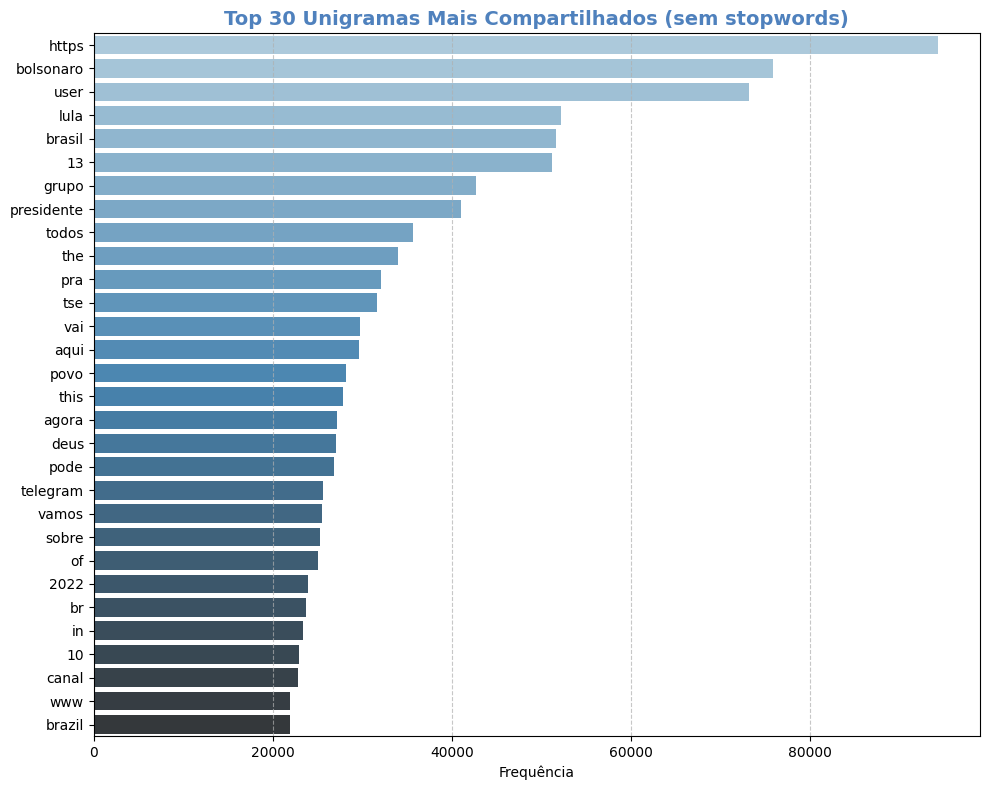

C:\Users\esthe\AppData\Local\Temp\ipykernel_3008\1333570217.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngrams, palette='Blues_d')


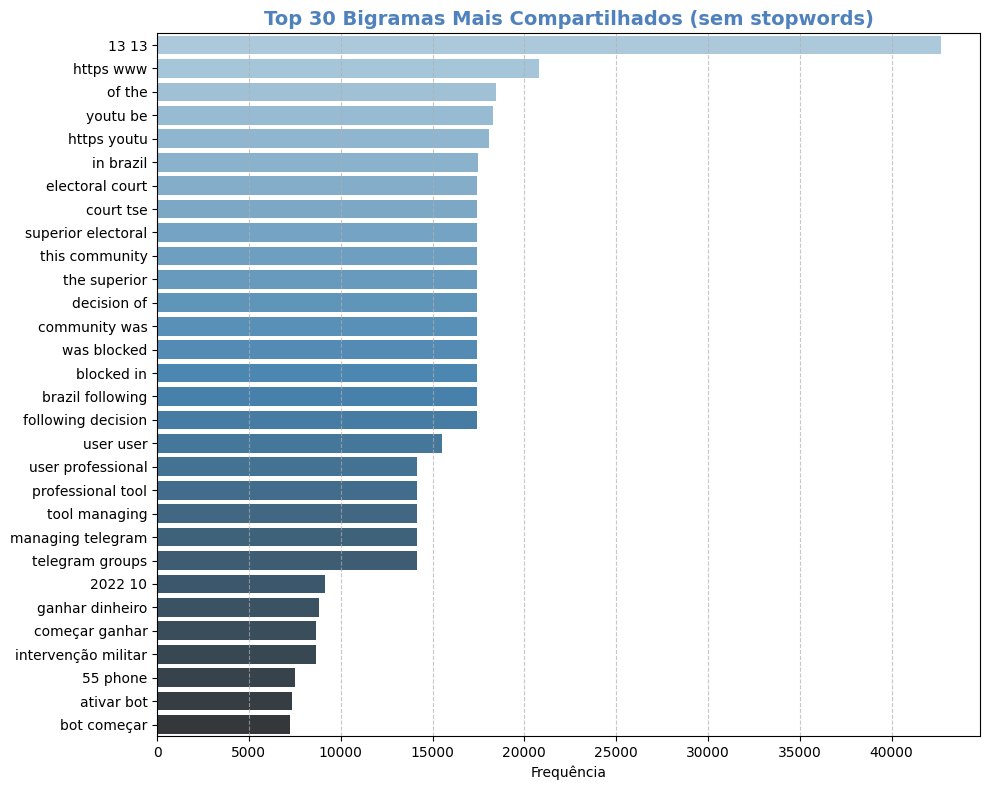

C:\Users\esthe\AppData\Local\Temp\ipykernel_3008\1333570217.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Ngram', data=df_ngrams, palette='Blues_d')


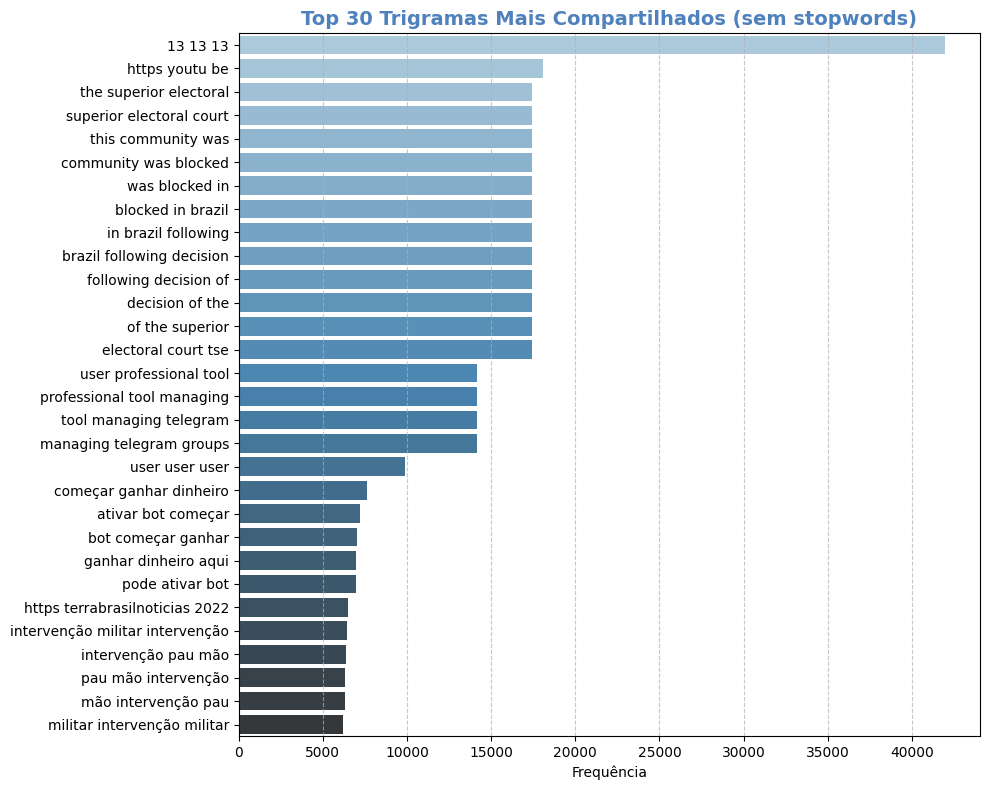

In [52]:
# 1. Preparando a lista de stopwords
stop_words = list(stopwords.words('portuguese'))

# 2. Função para extrair os n-gramas mais comuns
def get_top_ngrams(corpus, ngram_range=(1,1), n=None):
    """
    Extrai os ngramas mais frequentes de uma lista de textos.
    Parâmetros:
    - corpus: lista ou coluna de textos
    - ngram_range: tupla definindo o tamanho do ngrama (ex: (1,1) unigrama, (2,2) bigrama)
    - n: número dos top ngramas para retornar
    Retorna um DataFrame com as palavras e suas contagens ordenadas.
    """
    vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)  # soma as ocorrências de cada n-grama
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    df_ngrams = pd.DataFrame(words_freq[:n], columns=['Ngram', 'Count'])
    return df_ngrams

# 3. Extraindo os top 30 unigramas, bigramas e trigramas
top_unigrams = get_top_ngrams(df_sem_mensagens_curtas['text_content_anonymous'], ngram_range=(1,1), n=30)
top_bigrams = get_top_ngrams(df_sem_mensagens_curtas['text_content_anonymous'], ngram_range=(2,2), n=30)
top_trigrams = get_top_ngrams(df_sem_mensagens_curtas['text_content_anonymous'], ngram_range=(3,3), n=30)

# 5. Função para plotar gráfico de barras horizontais padronizado
def plot_ngrams(df_ngrams, title):
    """
    Cria gráfico de barras horizontais para os ngramas mais comuns.
    """
    plt.figure(figsize=(10,8))
    sns.barplot(x='Count', y='Ngram', data=df_ngrams, palette='Blues_d')
    plt.title(title, fontsize=14, weight='bold', color='#4F81BD')
    plt.xlabel('Frequência')
    plt.ylabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 6. Exibindo os gráficos
plot_ngrams(top_unigrams, 'Top 30 Unigramas Mais Compartilhados (sem stopwords)')
plot_ngrams(top_bigrams, 'Top 30 Bigramas Mais Compartilhados (sem stopwords)')
plot_ngrams(top_trigrams, 'Top 30 Trigramas Mais Compartilhados (sem stopwords)')


#### 21. **As 30 mensagens mais positivas (distintas)**

In [ ]:
df_filtered = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# Selecionar 30 mensagens distintas mais positivas
top_30_positivas = df_filtered[['text_content_anonymous', 'score_sentiment']].drop_duplicates() \
    .sort_values(by='score_sentiment', ascending=False).head(30) \
    .reset_index(drop=True)

# truncar mensagens muito longas por questão de visualização 
def truncate_text(text, max_len=80):
    return text if len(text) <= max_len else text[:max_len] + '...'

top_30_positivas['Mensagem (truncada)'] = top_30_positivas['text_content_anonymous'].apply(truncate_text)
top_30_positivas = top_30_positivas.drop(columns=['text_content_anonymous'])
top_30_positivas = top_30_positivas.rename(columns={'score_sentiment': 'Score de Sentimento'})

# Exibir a tabela estilizada 
top_30_positivas.style \
    .background_gradient(cmap='Blues', subset=['Score de Sentimento']) \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

#### 22. **As 30 mensagens mais negativas (distintas)**

In [55]:
df_filtered = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# Seleciona as 30 mensagens distintas com os menores scores de sentimento (mais negativas)
top_30_negativas = df_filtered[['text_content_anonymous', 'score_sentiment']].drop_duplicates() \
    .sort_values(by='score_sentiment', ascending=True).head(30) \
    .reset_index(drop=True)

# Função para truncar mensagens muito longas para melhorar a visualização da tabela
def truncate_text(text, max_len=80):
    return text if len(text) <= max_len else text[:max_len] + '...'

# Aplica a função de truncamento e cria uma nova coluna para exibir as mensagens
top_30_negativas['Mensagem (truncada)'] = top_30_negativas['text_content_anonymous'].apply(truncate_text)

# Remove a coluna original de texto para focar na truncada
top_30_negativas = top_30_negativas.drop(columns=['text_content_anonymous'])

# Renomeia a coluna de score para um nome mais legível
top_30_negativas = top_30_negativas.rename(columns={'score_sentiment': 'Score de Sentimento'})

# Exibe a tabela estilizada, com coloração para o scores
top_30_negativas.style \
    .background_gradient(cmap='Reds_r', subset=['Score de Sentimento']) \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

#### 23. **O usuário mais otimista**

In [57]:
df_filtered = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# Pega a linha com o maior score_sentiment (mais otimista)
top_1_optimist = df_filtered.loc[df_filtered['score_sentiment'].idxmax(), ['id_member_anonymous', 'text_content_anonymous', 'score_sentiment']]

# Cria DataFrame só com essa linha pra exibir como tabela
df_top_1_optimist = pd.DataFrame([top_1_optimist])

# Renomeia as colunas pra ficar mais claro
df_top_1_optimist.columns = ['Usuário', 'Mensagem', 'Score de Sentimento']

# Exibe a tabela
df_top_1_optimist.style.set_properties(**{'text-align': 'left'})

#### 24. **O usuário mais pessimista**

In [58]:
df_filtered = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# Pega a linha com o menor score_sentiment (mais pessimista)
top_1_pessimist = df_filtered.loc[df_filtered['score_sentiment'].idxmin(), 
                                 ['id_member_anonymous', 'text_content_anonymous', 'score_sentiment']]

# Cria DataFrame só com essa linha pra exibir como tabela
df_top_1_pessimist = pd.DataFrame([top_1_pessimist])

# Renomeia as colunas para clareza
df_top_1_pessimist.columns = ['ID Membro Anônimo', 'Mensagem', 'Score de Sentimento']

# Exibe a tabela
df_top_1_pessimist.style.set_properties(**{'text-align': 'left'})

#### 25. **As 30 maiores mensagens**

In [60]:
df_filtered = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# Seleciona as 30 mensagens com maior quantidade de palavras
top_30_maiores = df_filtered[['text_content_anonymous', 'qtd_palavras']].drop_duplicates() \
    .sort_values(by='qtd_palavras', ascending=False).head(30).reset_index(drop=True)

# Exibe a tabela organizada
top_30_maiores.style.set_caption("Top 30 Mensagens com Maior Quantidade de Palavras") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', '#34495E'), ('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#2980B9'), ('color', 'white')]},
        {'selector': 'td', 'props': [('padding', '8px')]}
    ])

#### 26. **As 30 menores mensagens**

In [61]:
# Filtra mensagens válidas (não nulas e não vazias)
df_filtered = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# Seleciona as 30 mensagens distintas com menor quantidade de palavras
top_30_menores = df_filtered[['text_content_anonymous', 'qtd_palavras']].drop_duplicates() \
    .sort_values(by='qtd_palavras', ascending=True).head(30).reset_index(drop=True)

top_30_menores.style.set_caption("Top 30 Mensagens com Menor Quantidade de Palavras") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', '#34495E'), ('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#C0392B'), ('color', 'white')]},
        {'selector': 'td', 'props': [('padding', '8px')]}
    ])

#### 27. **O dia em que foi publicado a maior quantidade de mensagens**

In [63]:
# Agrupa por data da mensagem e conta quantas mensagens foram publicadas em cada dia
mensagens_por_dia = df_sem_mensagens_curtas.groupby('date_message').size().reset_index(name='quantidade_mensagens')

# Ordena em ordem decrescente para pegar o dia com mais mensagens
dia_mais_mensagens = mensagens_por_dia.sort_values(by='quantidade_mensagens', ascending=False).head(1)

dia_mais_mensagens.style.set_caption("Dia com Maior Quantidade de Mensagens Publicadas") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', '#2E86C1'), ('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#1B4F72'), ('color', 'white')]},
        {'selector': 'td', 'props': [('padding', '8px')]}
    ])


#### 28. **As mensagens que possuem as palavras “FACÇÃO” e “CRIMINOSA”**

In [66]:
# Filtra mensagens que não são nulas e não vazias
df_filtered = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# Filtra mensagens que contêm "FACÇÃO" e "CRIMINOSA" (case insensitive)
mensagens_fac_crim = df_filtered[
    df_filtered['text_content_anonymous'].str.contains('FACÇÃO', case=False, na=False) &
    df_filtered['text_content_anonymous'].str.contains('CRIMINOSA', case=False, na=False)
]

# Seleciona as colunas relevantes para exibir
tabela_formatada = mensagens_fac_crim[['id_member_anonymous', 'text_content_anonymous', 'score_sentiment']].reset_index(drop=True)

# Aplica estilo para melhor visualização da tabela
tabela_formatada.style\
    .set_properties(**{'text-align': 'left'})\
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#4F81BD'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]
    }])\
    .bar(subset=['score_sentiment'], color='#4F81BD')\
    .set_caption('Mensagens que Contêm as Palavras "FACÇÃO" e "CRIMINOSA"')


#### 29. **Quantidade de mensagens por dia e hora**

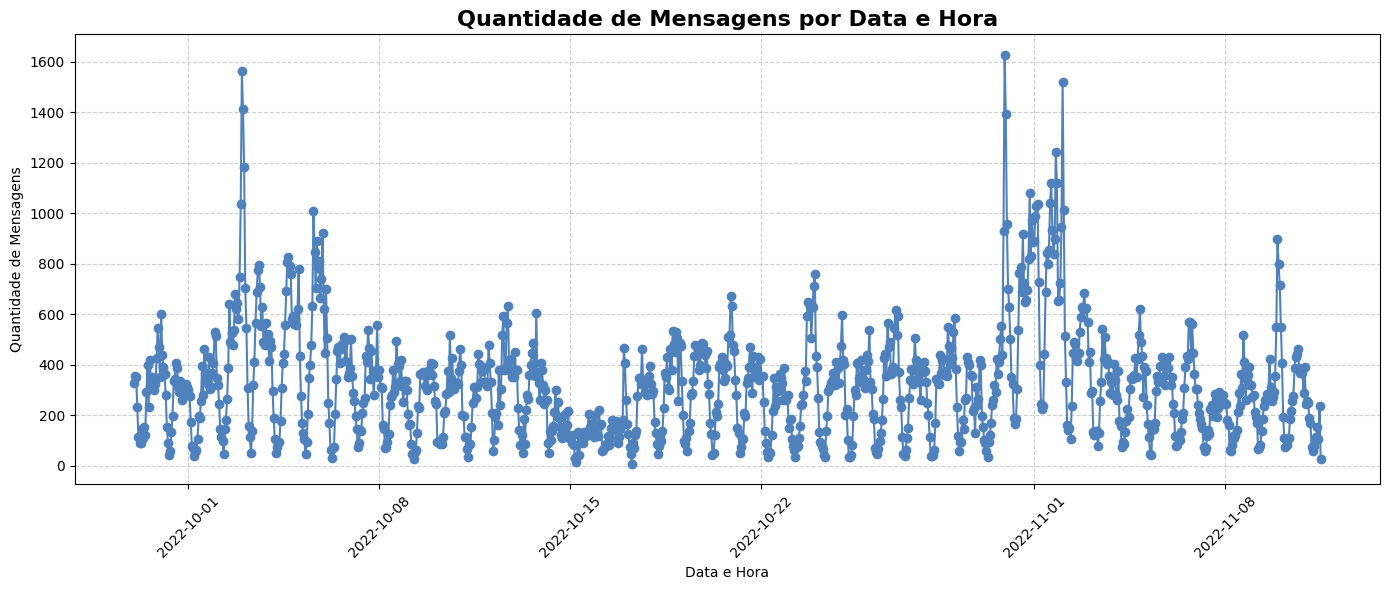

In [67]:
# Considerando que a coluna 'date_message' está em formato datetime 
df_sem_mensagens_curtas['date_message'] = pd.to_datetime(df_sem_mensagens_curtas['date_message'])

# Criar uma nova coluna com a data e hora (sem minutos e segundos)
df_sem_mensagens_curtas['date_hour'] = df_sem_mensagens_curtas['date_message'].dt.floor('H')

# Agrupar por data e hora e contar mensagens
mensagens_por_hora = df_sem_mensagens_curtas.groupby('date_hour').size().reset_index(name='qtd_mensagens')

# Plotar gráfico de linha
plt.figure(figsize=(14,6))
plt.plot(mensagens_por_hora['date_hour'], mensagens_por_hora['qtd_mensagens'], marker='o', linestyle='-', color='#4F81BD')
plt.title('Quantidade de Mensagens por Data e Hora', fontsize=16, weight='bold')
plt.xlabel('Data e Hora')
plt.ylabel('Quantidade de Mensagens')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 30. **Quantidade de mensagens por hora**

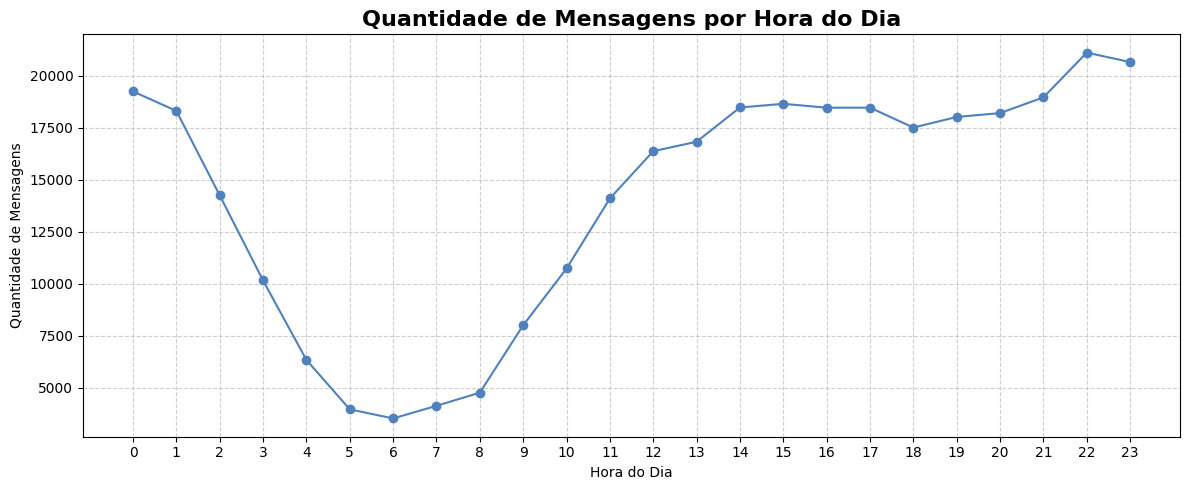

In [68]:
df_sem_mensagens_curtas['date_message'] = pd.to_datetime(df_sem_mensagens_curtas['date_message'])

# Extrai a hora do dia (0-23) da coluna date_message
df_sem_mensagens_curtas['hour'] = df_sem_mensagens_curtas['date_message'].dt.hour

# Agrupa por hora do dia e conta a quantidade de mensagens em cada hora
mensagens_por_hora = df_sem_mensagens_curtas.groupby('hour').size().reset_index(name='qtd_mensagens')

# Plotar gráfico de linha da quantidade de mensagens por hora do dia
plt.figure(figsize=(12,5))
plt.plot(mensagens_por_hora['hour'], mensagens_por_hora['qtd_mensagens'], marker='o', linestyle='-', color='#4F81BD')
plt.title('Quantidade de Mensagens por Hora do Dia', fontsize=16, weight='bold')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Mensagens')
plt.xticks(range(0,24))  # Mostrar todas as horas de 0 a 23 no eixo x
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### 31. **A nuvem de palavras referente às mensagens de texto (após a remoção de stop words)**

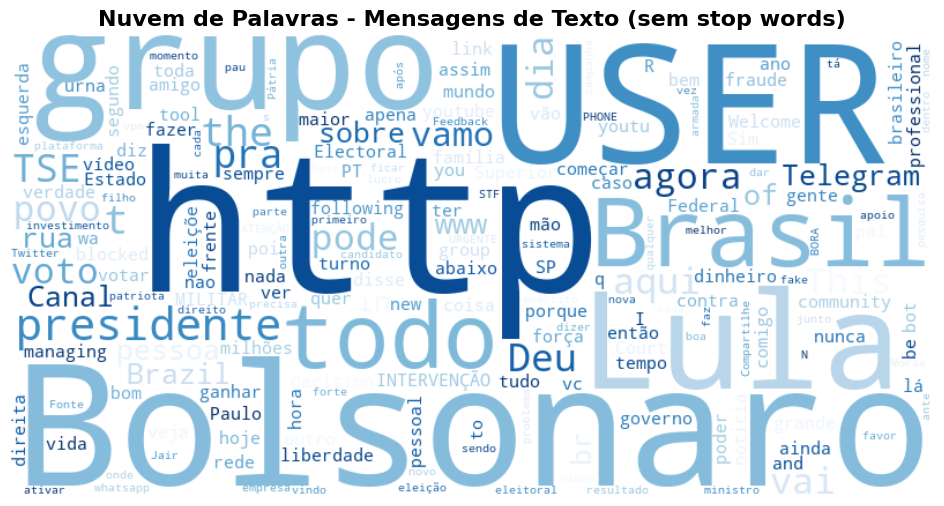

In [8]:
df_texto = df_sem_mensagens_curtas[
    (df_sem_mensagens_curtas['text_content_anonymous'].notnull()) &
    (df_sem_mensagens_curtas['text_content_anonymous'] != '')
]

# 2. Juntar todas as mensagens em uma única string para gerar a nuvem
texto_unido = " ".join(df_texto['text_content_anonymous'].tolist())

# 3. Definir stop words 
stop_words_pt = set(stopwords.words('portuguese'))

# 4. Criar o objeto WordCloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    stopwords=stop_words_pt, 
    collocations=False,  # para pegar bigramas
    colormap='Blues'
).generate(texto_unido)

# 5. Exibir a nuvem de palavras
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # remover eixos
plt.title('Nuvem de Palavras - Mensagens de Texto (sem stop words)', fontsize=16, weight='bold')
plt.show()


#### 32. **A rede interativa das palavras referente às mensagens de texto (após a remoção de stop words)**

In [ ]:
# 1. Pré-processamento otimizado
stop_words_pt = set(stopwords.words('portuguese'))

def preprocess_text(text):
    if pd.isna(text):
        return []
    text = re.sub(r'http\S+|www\S+|@\w+|[^\w\s]|\d+', '', str(text).lower())
    return [word for word in re.findall(r'\b\w+\b', text) 
            if word not in stop_words and len(word) > 2]

# Aplicar em chunks para evitar sobrecarga
chunk_size = 10000
co_occurrences = defaultdict(int)

for i in range(0, len(df_sem_mensagens_curtas), chunk_size):
    chunk = df_sem_mensagens_curtas.iloc[i:i+chunk_size]
    for tokens in chunk['text_content_anonymous'].apply(preprocess_text):
        unique_tokens = list(set(tokens))  # Remove duplicatas
        for i in range(len(unique_tokens)):
            for j in range(i+1, len(unique_tokens)):
                pair = tuple(sorted((unique_tokens[i], unique_tokens[j])))
                co_occurrences[pair] += 1

# 2. Filtrar pares relevantes (top 100)
top_pairs = sorted(co_occurrences.items(), key=lambda x: x[1], reverse=True)[:100]

# 3. Criar grafo
G = nx.Graph()
for (word1, word2), count in top_pairs:
    if count >= 3:  # Ajuste o limiar conforme necessário
        G.add_edge(word1, word2, weight=count)

# 4. Visualização (filtro para nós conectados)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, 
        with_labels=True, 
        node_size=50, 
        font_size=8, 
        edge_color='gray',
        width=[d['weight']*0.1 for (u, v, d) in G.edges(data=True)])
plt.title("Rede de Palavras (Top 100 Pares Co-ocorrentes)")
plt.show()

#### 33. **Proporção de mensagens com e sem URL**

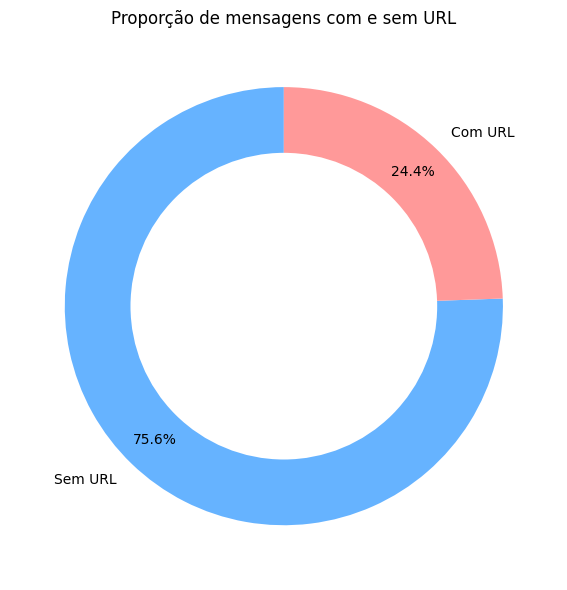

In [80]:
# Contar quantas mensagens têm URL (True) e não têm URL (False)
counts = df_sem_mensagens_curtas['has_media_url'].value_counts()

# Preparar os rótulos e cores
labels = ['Sem URL', 'Com URL']
sizes = [counts.get(False, 0), counts.get(True, 0)]
colors = ['#66b3ff', '#ff9999']

# Criar gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.title('Proporção de mensagens com e sem URL')
# Desenhar círculo branco no centro para dar efeito de rosquinha
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

#### 34. **Proporção de desinformação**

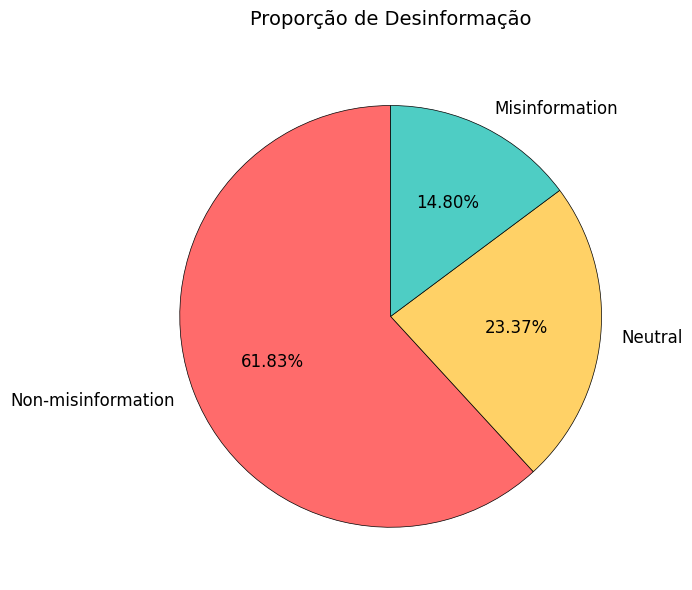

In [27]:
df_sem_mensagens_curtas['misinfo_category'] = pd.cut(
    df_sem_mensagens_curtas['score_misinformation'],
    bins=[-float('inf'), 0.3, 0.7, float('inf')],
    labels=['Non-misinformation', 'Neutral', 'Misinformation']
)

misinfo_proportions = df_sem_mensagens_curtas['misinfo_category'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.pie(
    misinfo_proportions,
    labels=misinfo_proportions.index,
    autopct='%1.2f%%',
    colors=['#FF6B6B', '#FFD166', '#4ECDC4'],  # Vermelho, Amarelo, Verde
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 12}
)

plt.title('Proporção de Desinformação', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


#### 35. **Proporção de mensagens contendo mídia e desinformação**

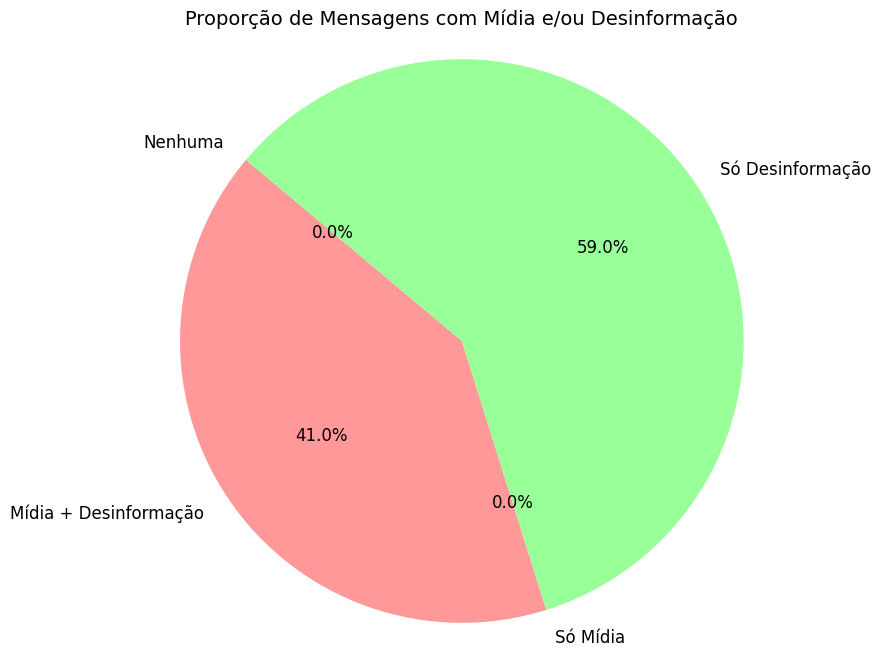

In [83]:
# Categorizar as mensagens
conditions = [
    (df_sem_mensagens_curtas['has_media'] == True) & (df_sem_mensagens_curtas['score_misinformation'] > 0),
    (df_sem_mensagens_curtas['has_media'] == True) & (df_sem_mensagens_curtas['score_misinformation'] == 0),
    (df_sem_mensagens_curtas['has_media'] == False) & (df_sem_mensagens_curtas['score_misinformation'] > 0),
    (df_sem_mensagens_curtas['has_media'] == False) & (df_sem_mensagens_curtas['score_misinformation'] == 0),
]

categories = [
    'Mídia + Desinformação',
    'Só Mídia',
    'Só Desinformação',
    'Nenhuma'
]

# Contar as ocorrências
counts = [cond.sum() for cond in conditions]

# Plotar gráfico de pizza
plt.figure(figsize=(8,8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#dddddd']
plt.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Proporção de Mensagens com Mídia e/ou Desinformação', fontsize=14)
plt.axis('equal')
plt.show()

#### 36. **Distribuição de mensagens por score de desinformação**

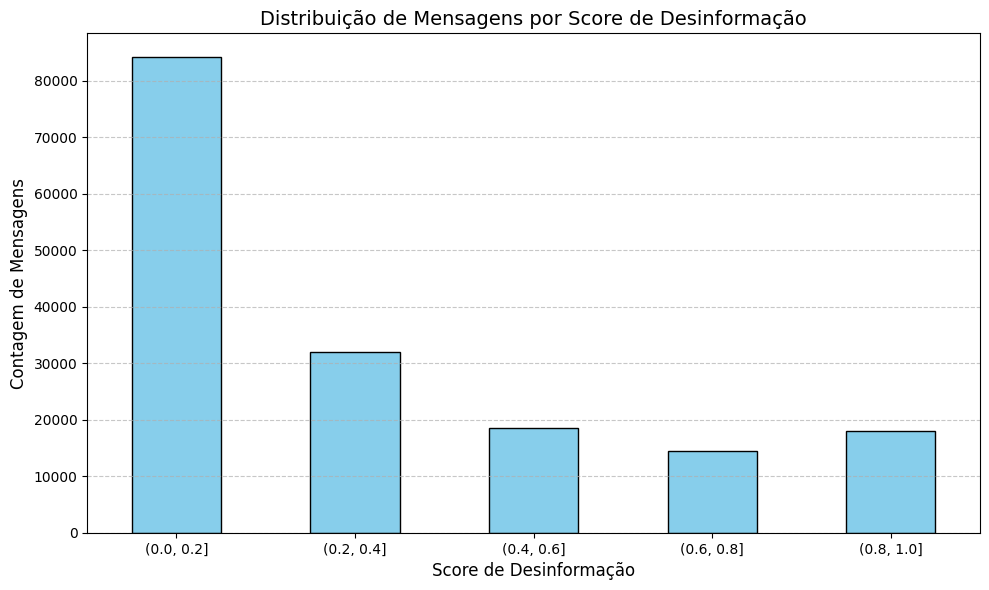

In [17]:
# 1. Definir os bins (intervalos de score)
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# 2. Criar categorias baseadas nos bins
df_sem_mensagens_curtas['misinformation_bin'] = pd.cut(df_sem_mensagens_curtas['score_misinformation'], bins=bins)

# 3. Contar mensagens por faixa de score
bin_counts = df_sem_mensagens_curtas['misinformation_bin'].value_counts().sort_index()

# 4. Plotar o gráfico de barras (histograma)
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# 5. Ajustar rótulos e título
plt.title('Distribuição de Mensagens por Score de Desinformação', fontsize=14)
plt.xlabel('Score de Desinformação', fontsize=12)
plt.ylabel('Contagem de Mensagens', fontsize=12)
plt.xticks(rotation=0)  # Rótulos horizontais

# 6. Mostrar o gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 37. **Proporção de sentimentos**

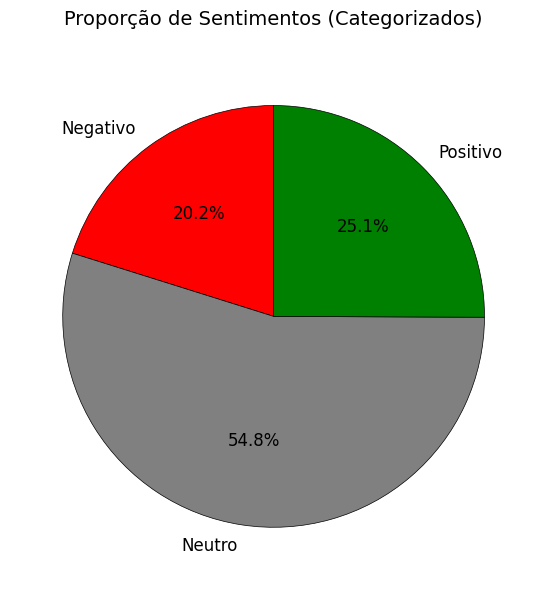

In [21]:
# 1. Categorizar os scores em Positivo, Neutro e Negativo
def categorize_sentiment(score):
    if score > 0.5:
        return "Positivo"
    elif score < -0.5:
        return "Negativo"
    else:
        return "Neutro"

df_sem_mensagens_curtas['sentiment_category'] = df_sem_mensagens_curtas['score_sentiment'].apply(categorize_sentiment)

# 2. Calcular a proporção de cada categoria
sentiment_proportions = df_sem_mensagens_curtas['sentiment_category'].value_counts(normalize=True) * 100

# 3. Ordenar as categorias (Negativo, Neutro, Positivo)
sentiment_proportions = sentiment_proportions.reindex(["Negativo", "Neutro", "Positivo"])

# 4. Criar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(
    sentiment_proportions,
    labels=sentiment_proportions.index,
    autopct='%1.1f%%',
    colors=['red', 'gray', 'green'],  # Vermelho (Negativo), Cinza (Neutro), Verde (Positivo)
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 12}
)

plt.title('Proporção de Sentimentos (Categorizados)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

#### 38. **Distribuição de mensagens por score de sentimentos**

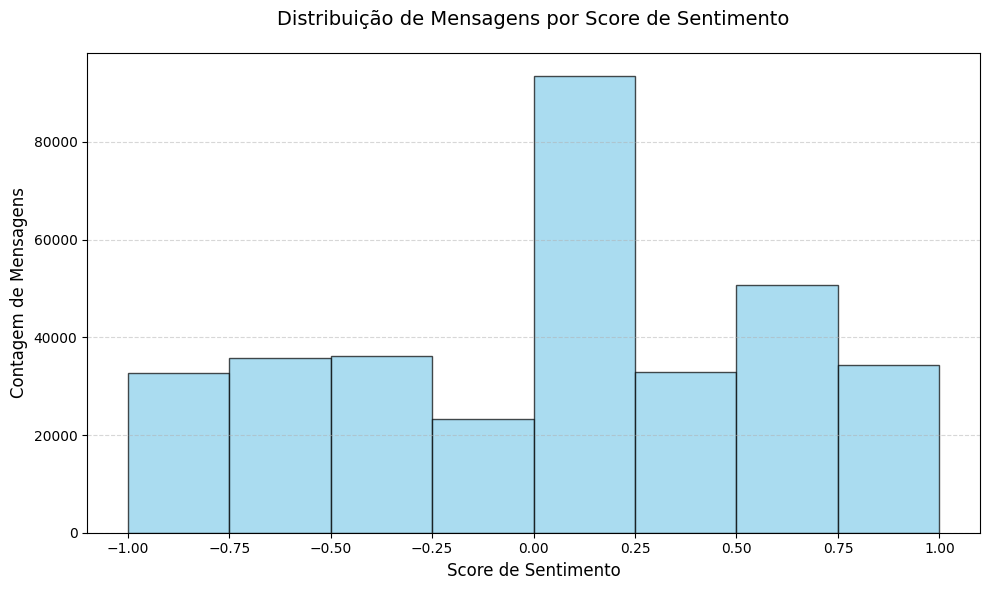

In [20]:
# 1. Definir os bins (intervalos de score)
bins = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]

# 2. Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(
    df_sem_mensagens_curtas['score_sentiment'], 
    bins=bins, 
    color='skyblue', 
    edgecolor='black',
    alpha=0.7
)

# 3. Personalizar o gráfico
plt.title('Distribuição de Mensagens por Score de Sentimento', fontsize=14, pad=20)
plt.xlabel('Score de Sentimento', fontsize=12)
plt.ylabel('Contagem de Mensagens', fontsize=12)
plt.xticks(bins)  # Garante que todos os bins apareçam no eixo X
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Linhas de grade horizontais

# 4. Mostrar o gráfico
plt.tight_layout()
plt.show()

#### 39. **Proporção entre mensagens virais e não virais**

Assumindo que mensagens com alto score de desinformação poderiam ser mais propensas a serem virais

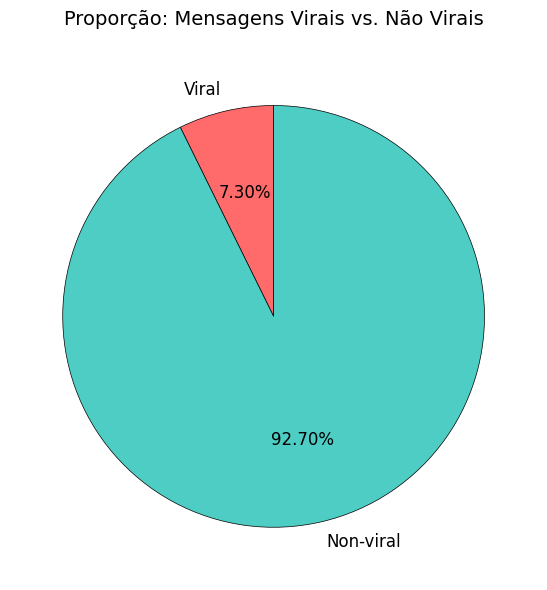

In [22]:
df_sem_mensagens_curtas['viral_category'] = df_sem_mensagens_curtas['score_misinformation'].apply(lambda x: 'Viral' if x > 0.7 else 'Non-viral')

# 2. Calcular proporções
viral_proportions = df_sem_mensagens_curtas['viral_category'].value_counts(normalize=True) * 100

# 3. Ordenar as categorias (Viral primeiro)
viral_proportions = viral_proportions.reindex(['Viral', 'Non-viral'])

# 4. Criar gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(
    viral_proportions,
    labels=viral_proportions.index,
    autopct='%1.2f%%',  # 2 casas decimais (para valores como 6.38%)
    colors=['#FF6B6B', '#4ECDC4'],  # Vermelho (Viral), Verde-água (Non-viral)
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 12}
)

plt.title('Proporção: Mensagens Virais vs. Não Virais', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

#### 40. **Algo que você julga importante e que ainda não foi solicitado**

##### Média de Fake News divulgada por dia

1. Definição de Fake News
Usaremos a coluna `score_misinformation` e considerar como fake news mensagens com:
    - score_misinformation > 0.7 (limiar ajustável) ou

2. Filtrar e Agrupar por Dia
    - Extrair a data da coluna date_message.

3. Contar fake news por dia e calcular a média.

Média de fake news por dia: 562.59


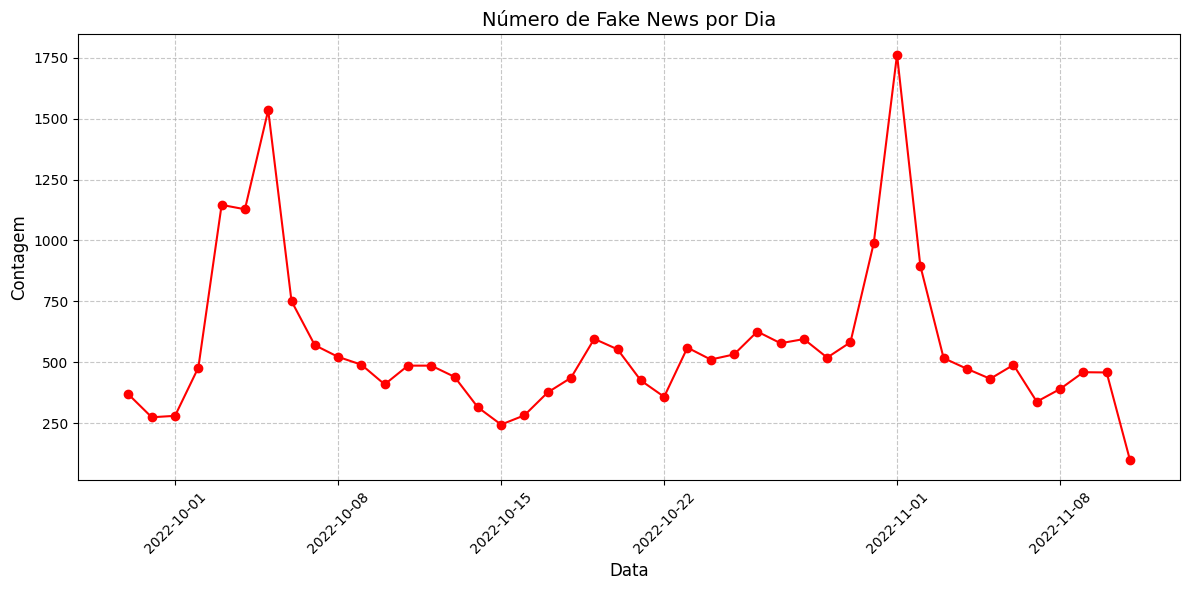

In [23]:
# 1. Definir fake news (critério: score_misinformation > 0.7)
df_sem_mensagens_curtas['is_fake'] = df_sem_mensagens_curtas['score_misinformation'] > 0.7  # Ajuste o limiar conforme necessário

# 2. Converter 'date_message' para datetime e extrair a data
df_sem_mensagens_curtas['date'] = pd.to_datetime(df_sem_mensagens_curtas['date_message']).dt.date

# 3. Contar fake news por dia
fake_news_daily = df_sem_mensagens_curtas[df_sem_mensagens_curtas['is_fake']].groupby('date').size().reset_index(name='count')

# 4. Calcular a média diária
average_fake_per_day = fake_news_daily['count'].mean()

print(f"Média de fake news por dia: {average_fake_per_day:.2f}")

# Opcional: Plotar tendência temporal
plt.figure(figsize=(12, 6))
plt.plot(fake_news_daily['date'], fake_news_daily['count'], marker='o', linestyle='-', color='red')
plt.title('Número de Fake News por Dia', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---

# Fontes

- [Matplotlib 3.10.3 documentation](https://matplotlib.org/stable/index.html)
- [Seaborn Documentation](seaborn.histplot)
- [Statistical Data Visualization with Seaborn](https://seaborn.pydata.org/tutorial.html)
- [Urlparse Lib Documentation](https://docs.python.org/pt-br/3/library/urllib.parse.html)